In [ ]:
%pip install torch optuna seaborn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 7.9 MB/s eta 0:00:00


In [ ]:
import optuna
import torch
import pandas as pd
import seaborn as sns
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

data = pd.read_csv('data.csv', encoding='ISO-8859-1')  # Lectura de caracteres o signos especiales del espanol


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701083 entries, 0 to 701082
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Dia                 701083 non-null  object 
 1   Hora                701083 non-null  object 
 2   Latitud Central     701083 non-null  float64
 3   Longitud Central    701083 non-null  float64
 4   Tipo de Via         701083 non-null  object 
 5   Congestion          701083 non-null  object 
 6   Congestion_Numeric  701083 non-null  int64  
 7   Distance            701083 non-null  float64
 8   Duration            701083 non-null  float64
dtypes: float64(4), int64(1), object(4)
memory usage: 48.1+ MB


In [ ]:
data.describe().T

count       mean        std        min        25%  \
Latitud Central     701083.0 -12.123855   0.045094 -12.225161 -12.159201   
Longitud Central    701083.0 -77.018400   0.031615 -77.110631 -77.034910   
Congestion_Numeric  701083.0   3.983951   9.269304  -1.000000  -1.000000   
Distance            701083.0  42.452196  42.411308   0.000000  10.800000   
Duration            701083.0   7.929850   8.110030   0.000000   2.113000   

                          50%        75%         max  
Latitud Central    -12.111800 -12.086533  -12.051969  
Longitud Central   -77.014755 -76.994466  -76.953908  
Congestion_Numeric   0.000000   4.000000   91.000000  
Distance            27.100000  61.700000  726.300000  
Duration             5.172000  11.227500  165.029000

In [ ]:
data.head()

Dia   Hora  Latitud Central  Longitud Central  \
0  Sunday  20:20       -12.218011        -76.977544   
1  Sunday  20:20       -12.219672        -76.976457   
2  Sunday  20:20       -12.220101        -76.975983   
3  Sunday  20:20       -12.214297        -76.982415   
4  Sunday  20:20       -12.217824        -76.978839   

                  Tipo de Via Congestion  Congestion_Numeric  Distance  \
0  carretera panamericana sur    unknown                  -1       7.8   
1  carretera panamericana sur        low                   0      19.3   
2  carretera panamericana sur        low                  17      17.7   
3    avenida caminos del inca        low                   0      19.1   
4    avenida caminos del inca    unknown                  -1      20.9   

   Duration  
0     1.846  
1     0.722  
2     5.536  
3     1.723  
4     5.026

In [ ]:

# Convertir el día a valores numéricos (label encoding)
label_encoder = LabelEncoder()
data['Dia'] = label_encoder.fit_transform(data['Dia'])
data.head()

Dia   Hora  Latitud Central  Longitud Central                 Tipo de Via  \
0    2  20:20       -12.218011        -76.977544  carretera panamericana sur   
1    2  20:20       -12.219672        -76.976457  carretera panamericana sur   
2    2  20:20       -12.220101        -76.975983  carretera panamericana sur   
3    2  20:20       -12.214297        -76.982415    avenida caminos del inca   
4    2  20:20       -12.217824        -76.978839    avenida caminos del inca   

  Congestion  Congestion_Numeric  Distance  Duration  
0    unknown                  -1       7.8     1.846  
1        low                   0      19.3     0.722  
2        low                  17      17.7     5.536  
3        low                   0      19.1     1.723  
4    unknown                  -1      20.9     5.026

In [ ]:
# Convertir la hora a minutos totales desde medianoche
data['Hora'] = pd.to_datetime(data['Hora'], format='%H:%M').dt.hour * 60 + pd.to_datetime(data['Hora'], format='%H:%M').dt.minute
data.head()

Dia  Hora  Latitud Central  Longitud Central                 Tipo de Via  \
0    2  1220       -12.218011        -76.977544  carretera panamericana sur   
1    2  1220       -12.219672        -76.976457  carretera panamericana sur   
2    2  1220       -12.220101        -76.975983  carretera panamericana sur   
3    2  1220       -12.214297        -76.982415    avenida caminos del inca   
4    2  1220       -12.217824        -76.978839    avenida caminos del inca   

  Congestion  Congestion_Numeric  Distance  Duration  
0    unknown                  -1       7.8     1.846  
1        low                   0      19.3     0.722  
2        low                  17      17.7     5.536  
3        low                   0      19.1     1.723  
4    unknown                  -1      20.9     5.026

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 701083 entries, 0 to 701082
Data columns (total 9 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Dia                 701083 non-null  int64  
 1   Hora                701083 non-null  int32  
 2   Latitud Central     701083 non-null  float64
 3   Longitud Central    701083 non-null  float64
 4   Tipo de Via         701083 non-null  object 
 5   Congestion          701083 non-null  object 
 6   Congestion_Numeric  701083 non-null  int64  
 7   Distance            701083 non-null  float64
 8   Duration            701083 non-null  float64
dtypes: float64(4), int32(1), int64(2), object(2)
memory usage: 45.5+ MB


In [ ]:
data = data.drop(columns='Congestion', axis=1)
data.head()

Dia  Hora  Latitud Central  Longitud Central                 Tipo de Via  \
0    2  1220       -12.218011        -76.977544  carretera panamericana sur   
1    2  1220       -12.219672        -76.976457  carretera panamericana sur   
2    2  1220       -12.220101        -76.975983  carretera panamericana sur   
3    2  1220       -12.214297        -76.982415    avenida caminos del inca   
4    2  1220       -12.217824        -76.978839    avenida caminos del inca   

   Congestion_Numeric  Distance  Duration  
0                  -1       7.8     1.846  
1                   0      19.3     0.722  
2                  17      17.7     5.536  
3                   0      19.1     1.723  
4                  -1      20.9     5.026

In [ ]:
df_original = data
df_original.head()

Dia  Hora  Latitud Central  Longitud Central                 Tipo de Via  \
0    2  1220       -12.218011        -76.977544  carretera panamericana sur   
1    2  1220       -12.219672        -76.976457  carretera panamericana sur   
2    2  1220       -12.220101        -76.975983  carretera panamericana sur   
3    2  1220       -12.214297        -76.982415    avenida caminos del inca   
4    2  1220       -12.217824        -76.978839    avenida caminos del inca   

   Congestion_Numeric  Distance  Duration  
0                  -1       7.8     1.846  
1                   0      19.3     0.722  
2                  17      17.7     5.536  
3                   0      19.1     1.723  
4                  -1      20.9     5.026

In [ ]:
data = data[data['Congestion_Numeric'] != -1]
data.head()

Dia  Hora  Latitud Central  Longitud Central                 Tipo de Via  \
1    2  1220       -12.219672        -76.976457  carretera panamericana sur   
2    2  1220       -12.220101        -76.975983  carretera panamericana sur   
3    2  1220       -12.214297        -76.982415    avenida caminos del inca   
5    2  1220       -12.219575        -76.977372    avenida caminos del inca   
9    2  1220       -12.216620        -76.980104               motorway_link   

   Congestion_Numeric  Distance  Duration  
1                   0      19.3     0.722  
2                  17      17.7     5.536  
3                   0      19.1     1.723  
5                   0       7.9     0.682  
9                   0      39.0     2.924

Información general del dataset:
<class 'pandas.core.frame.DataFrame'>
Index: 408901 entries, 1 to 701082
Data columns (total 8 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   Dia                 408901 non-null  int64  
 1   Hora                408901 non-null  int32  
 2   Latitud Central     408901 non-null  float64
 3   Longitud Central    408901 non-null  float64
 4   Tipo de Via         408901 non-null  object 
 5   Congestion_Numeric  408901 non-null  int64  
 6   Distance            408901 non-null  float64
 7   Duration            408901 non-null  float64
dtypes: float64(4), int32(1), int64(2), object(1)
memory usage: 26.5+ MB
None

Primeras filas del dataset:
   Dia  Hora  Latitud Central  Longitud Central                 Tipo de Via  \
1    2  1220       -12.219672        -76.976457  carretera panamericana sur   
2    2  1220       -12.220101        -76.975983  carretera panamericana sur   
3    2  1220      

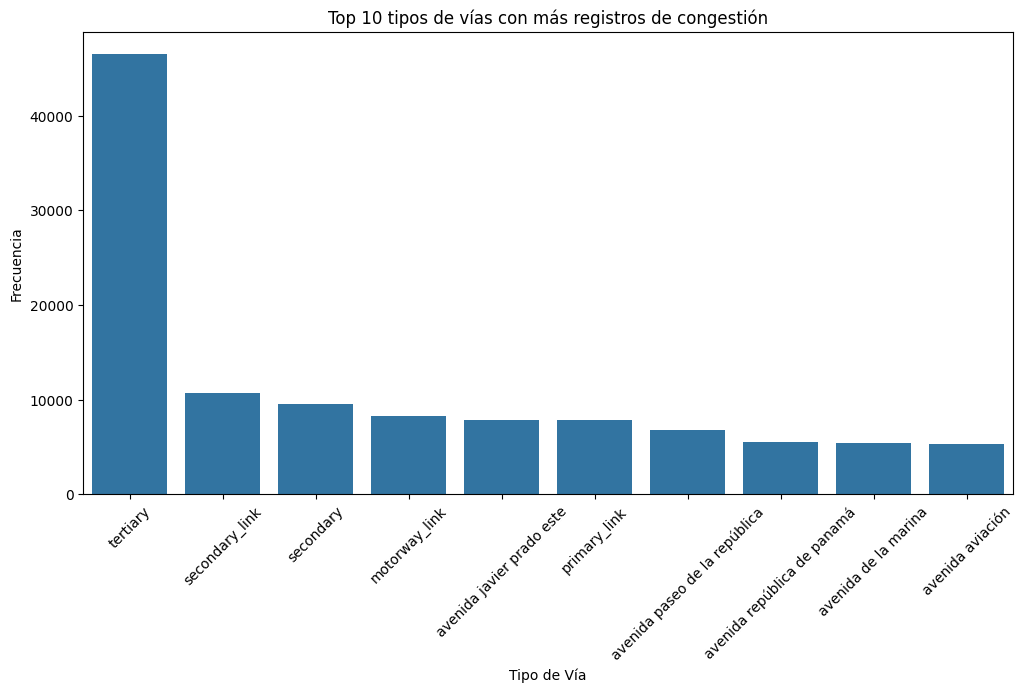

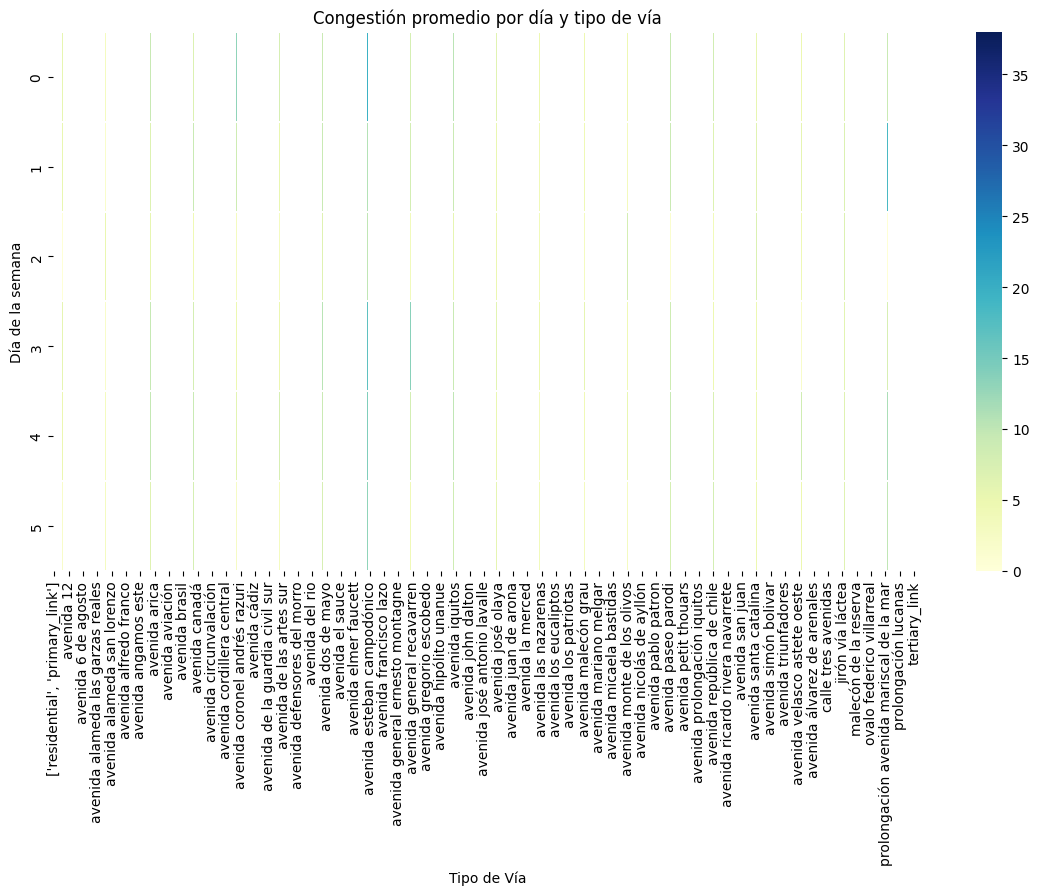

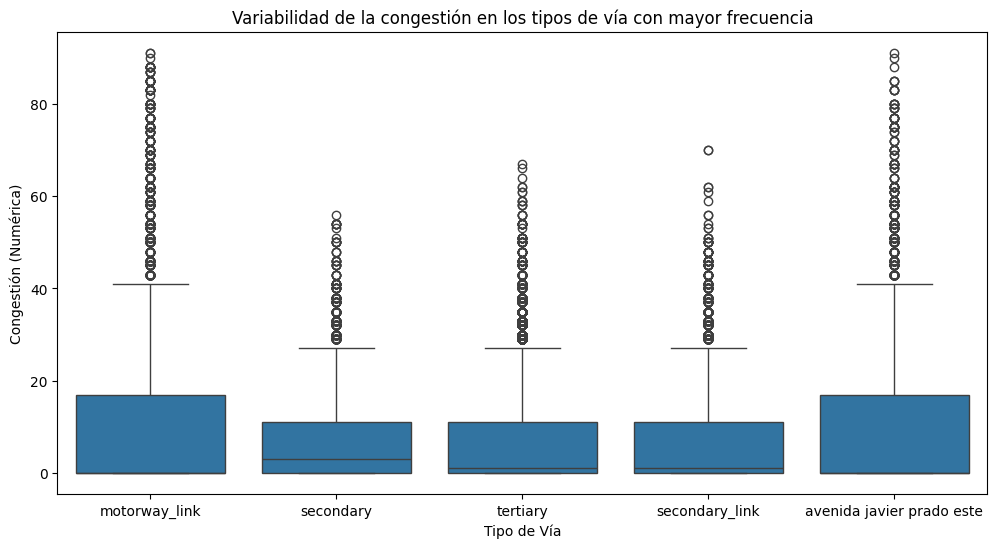

In [ ]:

# Cargar los datos de ejemplo
# Asegúrate de ajustar el nombre del archivo y la ruta
df = data  # Coloca aquí tu archivo real

# Exploración inicial
print("Información general del dataset:")
print(df.info())
print("\nPrimeras filas del dataset:")
print(df.head())

# 1. Frecuencia de aparición de cada tipo de vía
via_frecuencia = df['Tipo de Via'].value_counts()
print("\nFrecuencia de aparición por tipo de vía:")
print(via_frecuencia.head(10))

# Visualización de las vías con mayor frecuencia
plt.figure(figsize=(12, 6))
sns.barplot(x=via_frecuencia.head(10).index, y=via_frecuencia.head(10).values)
plt.xticks(rotation=45)
plt.title("Top 10 tipos de vías con más registros de congestión")
plt.xlabel("Tipo de Vía")
plt.ylabel("Frecuencia")
plt.show()

# 2. Distribución de congestión por día y tipo de vía
# Crear una columna para el día de la semana si no está ya categorizado


# Calcular la congestión promedio por día de la semana y tipo de vía
congestion_dia_via = df.groupby(['Dia', 'Tipo de Via'])['Congestion_Numeric'].mean().unstack()

# Visualización de congestión promedio por día y tipo de vía
plt.figure(figsize=(14, 7))
sns.heatmap(congestion_dia_via, cmap="YlGnBu", linewidths=0.1)
plt.title("Congestión promedio por día y tipo de vía")
plt.xlabel("Tipo de Vía")
plt.ylabel("Día de la semana")
plt.show()

# 3. Variabilidad de la congestión en las vías con mayor frecuencia
# Seleccionamos los tipos de vía con mayor frecuencia de datos
top_vias = via_frecuencia.head(5).index
df_top_vias = df[df['Tipo de Via'].isin(top_vias)]

# Visualizar la congestión a lo largo del tiempo para estos tipos de vía
plt.figure(figsize=(12, 6))
sns.boxplot(x='Tipo de Via', y='Congestion_Numeric', data=df_top_vias)
plt.title("Variabilidad de la congestión en los tipos de vía con mayor frecuencia")
plt.xlabel("Tipo de Vía")
plt.ylabel("Congestión (Numérica)")
plt.show()


Número de ocurrencias por calle:
Tipo de Via
tertiary                         46496
secondary_link                   10654
secondary                         9551
motorway_link                     8215
avenida javier prado este         7824
primary_link                      7788
avenida paseo de la república     6835
avenida república de panamá       5529
avenida de la marina              5457
avenida aviación                  5278
Name: count, dtype: int64


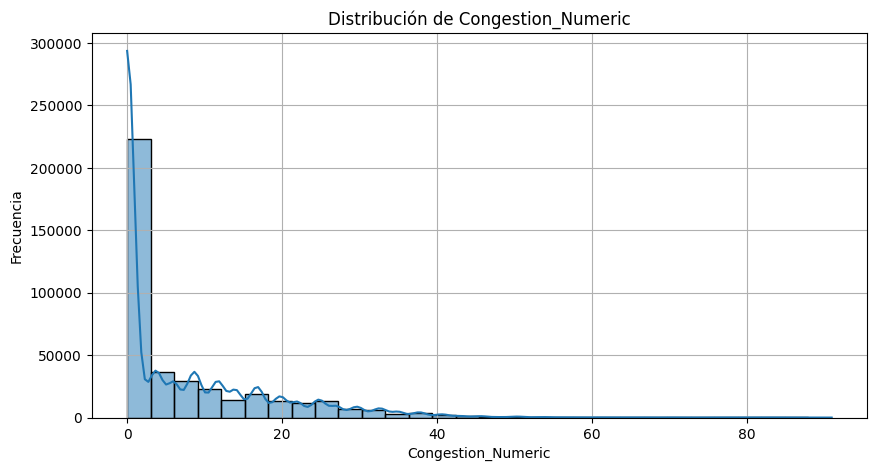


Promedio de Congestion_Numeric por calle (Top 10):
Tipo de Via
avenida los horticultores               26.813953
avenida jorge basadre                   24.604396
avenida oscar de la barrera             20.307692
carretera panamericana sur              18.290076
avenida panamericana sur                17.389944
vía expresa luis fernán bedoya reyes    17.021006
circuito de playas                      15.387384
avenida miraflores                      14.711111
avenida españa                          14.369863
avenida dionisio derteano               14.075000
Name: Congestion_Numeric, dtype: float64


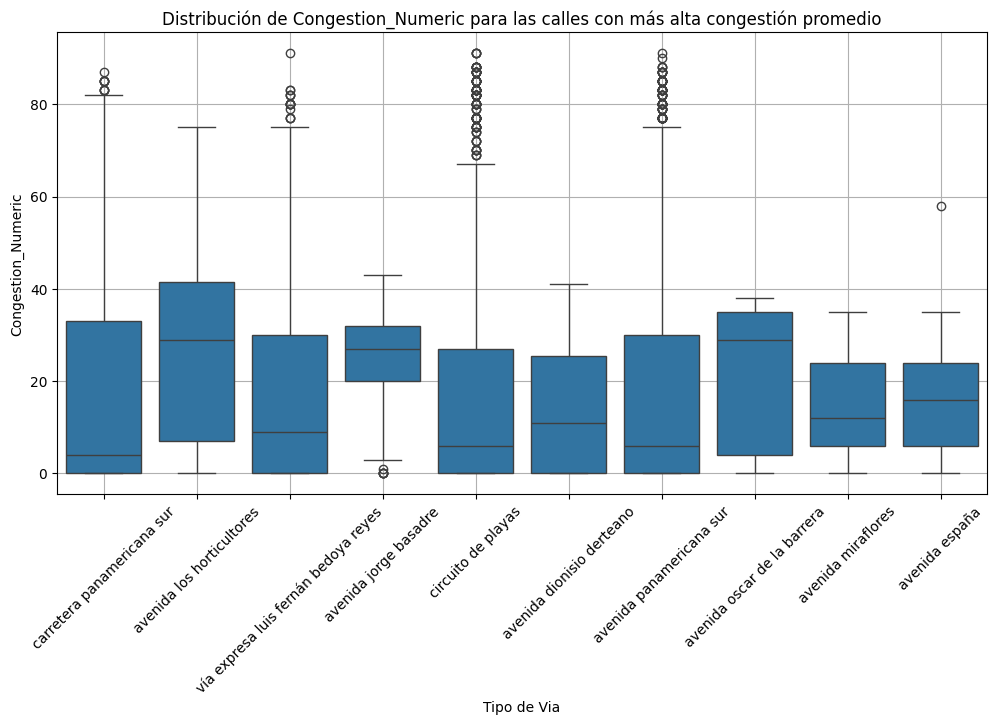


Porcentaje de datos con alta congestión: 36.53%


In [ ]:
street_counts = df['Tipo de Via'].value_counts()
print("Número de ocurrencias por calle:")
print(street_counts.head(10))

plt.figure(figsize=(10, 5))
sns.histplot(df['Congestion_Numeric'], bins=30, kde=True)
plt.title("Distribución de Congestion_Numeric")
plt.xlabel("Congestion_Numeric")
plt.ylabel("Frecuencia")
plt.grid(True)
plt.show()

avg_congestion_per_street = df.groupby('Tipo de Via')['Congestion_Numeric'].mean().sort_values(ascending=False)
print("\nPromedio de Congestion_Numeric por calle (Top 10):")
print(avg_congestion_per_street.head(10))

top_congested_streets = avg_congestion_per_street.head(10).index
top_congested_data = df[df['Tipo de Via'].isin(top_congested_streets)]

plt.figure(figsize=(12, 6))
sns.boxplot(data=top_congested_data, x='Tipo de Via', y='Congestion_Numeric')
plt.xticks(rotation=45)
plt.title("Distribución de Congestion_Numeric para las calles con más alta congestión promedio")
plt.xlabel("Tipo de Via")
plt.ylabel("Congestion_Numeric")
plt.grid(True)
plt.show()

high_congestion = df[df['Congestion_Numeric'] > df['Congestion_Numeric'].mean()]
high_congestion_percentage = (len(high_congestion) / len(df)) * 100
print(f"\nPorcentaje de datos con alta congestión: {high_congestion_percentage:.2f}%")


In [ ]:
data.info()

In [ ]:
calles_principales = [
    'avenida javier prado este', 'avenida javier prado oeste', 'avenida la marina',
    'avenida antonio josé de sucre', 'avenida faustino sanchez carrión','avenida del ejército',
    'ovalo josé quiñones', 'circuito de playas',
    'avenida del parque norte', 'avenida general salaverry', 'avenida la paz',
    'avenida san borja norte', 'avenida lima polo', 'avenida panamericana sur',
    'avenida primavera', 'avenida el derby','avenida angamos este', 'avenida angamos oeste',
    'avenida alfredo benavides'
]

data = data[data['Tipo de Via'].isin(calles_principales)]

data.info()

Dia  Hora  Latitud Central  Longitud Central                Tipo de Via  \
973    2  1223       -12.113701        -77.029861       avenida angamos este   
974    2  1223       -12.113170        -77.029878       avenida angamos este   
979    2  1223       -12.124516        -77.029388  avenida alfredo benavides   
980    2  1223       -12.124666        -77.028660  avenida alfredo benavides   
991    2  1223       -12.113740        -77.029938      avenida angamos oeste   

     Congestion_Numeric  Distance  Duration  
973                  20       7.8     1.764  
974                  14       8.9     1.594  
979                   0       8.1     2.094  
980                  14       8.9     2.010  
991                  12       8.1     2.084

In [ ]:

X = data[['Dia','Hora','Latitud Central','Longitud Central','Tipo de Via']]
y = data['Congestion_Numeric']

# X = pd.get_dummies(X, columns=['Tipo de Via'])
X = X.drop(columns='Tipo de Via', axis=1)

In [ ]:
X.sample()

Dia  Hora  Latitud Central  Longitud Central
677912    0  1249       -12.087421         -77.00001

In [ ]:
X.replace({True: 1, False: 0}, inplace=True)

X.head()

Dia  Hora  Latitud Central  Longitud Central
973    2  1223       -12.113701        -77.029861
974    2  1223       -12.113170        -77.029878
979    2  1223       -12.124516        -77.029388
980    2  1223       -12.124666        -77.028660
991    2  1223       -12.113740        -77.029938

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train, y_train)

smote = SMOTE(random_state=42, k_neighbors=1)
X_train, y_train = smote.fit_resample(X_train_resampled, y_train_resampled)

Distribución después de SMOTE en los datos de entrenamiento:
Congestion_Numeric
35    16558
62    16558
29    16558
67    16558
59    16558
83    16558
43    16558
75    16558
51    16558
85    16558
50    16558
40    16558
66    16558
58    16558
80    16558
0     16558
74    16558
54    16558
48    16558
56    16558
72    16558
82    16558
87    16558
77    16558
88    16558
91    16558
70    16558
69    16558
32    16558
46    16558
3     16558
45    16558
64    16558
6     16558
61    16558
25    16558
33    16558
4     16558
9     16558
41    16558
1     16558
8     16558
14    16558
30    16558
79    16558
11    16558
37    16558
53    16558
27    16558
38    16558
22    16558
17    16558
19    16558
12    16558
16    16558
20    16558
24    16558
90    16558
Name: count, dtype: int64


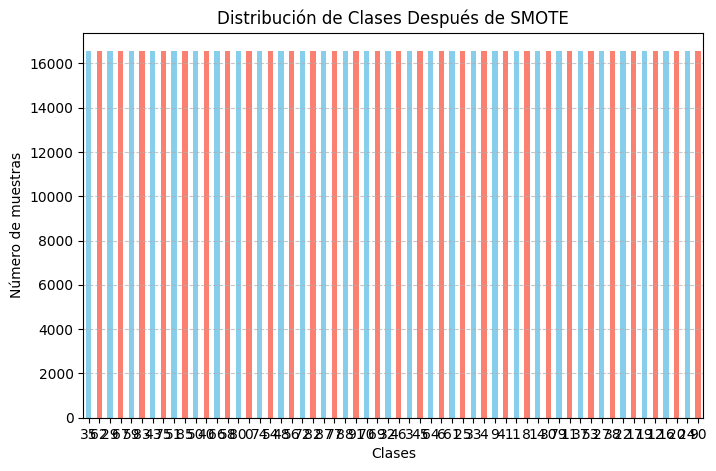

In [ ]:
print("Distribución después de SMOTE en los datos de entrenamiento:")
print(y_train.value_counts())

plt.figure(figsize=(8, 5))
y_train.value_counts().plot(kind='bar', color=['skyblue', 'salmon'])
plt.title('Distribución de Clases Después de SMOTE')
plt.xlabel('Clases')
plt.ylabel('Número de muestras')
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
scaler_X = StandardScaler()
X_train = scaler_X.fit_transform(X_train)
X_test = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train = scaler_y.fit_transform(y_train.values.reshape(-1, 1))
y_test = scaler_y.transform(y_test.values.reshape(-1, 1))

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).view(-1, 1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).view(-1, 1)

In [ ]:
X.head()

Dia  Hora  Latitud Central  Longitud Central
973    2  1223       -12.113701        -77.029861
974    2  1223       -12.113170        -77.029878
979    2  1223       -12.124516        -77.029388
980    2  1223       -12.124666        -77.028660
991    2  1223       -12.113740        -77.029938

In [ ]:
import torch._dynamo
torch._dynamo.config.suppress_errors = True

class TrafficModel(nn.Module):
    def __init__(self, input_size, hidden_sizes, output_size):
        super(TrafficModel, self).__init__()
        layers = []
        in_size = input_size
        for h in hidden_sizes:
            layers.append(nn.Linear(in_size, h))
            layers.append(nn.ReLU())
            in_size = h
        layers.append(nn.Linear(in_size, output_size))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

In [ ]:
import torch
import numpy as np

def reduce_rows(X_train, X_test, y_train, y_test, n_rows=30000):
    test_ratio = len(X_test) / len(X_train)
    n_rows_test = int(n_rows * test_ratio)

    train_indices = torch.randperm(len(X_train))[:n_rows]
    test_indices = torch.randperm(len(X_test))[:n_rows_test]

    X_train_small = X_train[train_indices]
    y_train_small = y_train[train_indices]
    X_test_small = X_test[test_indices]
    y_test_small = y_test[test_indices]

    print(f"Tamaño original del conjunto de entrenamiento: {len(X_train)}")
    print(f"Nuevo tamaño del conjunto de entrenamiento: {len(X_train_small)}")
    print(f"Tamaño original del conjunto de prueba: {len(X_test)}")
    print(f"Nuevo tamaño del conjunto de prueba: {len(X_test_small)}")

    return X_train_small, X_test_small, y_train_small, y_test_small

X_train_small, X_test_small, y_train_small, y_test_small = reduce_rows(
    X_train_tensor,
    X_test_tensor,
    y_train_tensor,
    y_test_tensor,
    n_rows=30000
)

Tamaño original del conjunto de entrenamiento: 960364
Nuevo tamaño del conjunto de entrenamiento: 30000
Tamaño original del conjunto de prueba: 9885
Nuevo tamaño del conjunto de prueba: 308


[I 2024-11-13 22:03:50,594] A new study created in memory with name: no-name-69ac3583-330d-4a5d-8692-dc30fb4a1593
<ipython-input-26-66222cd4cd82>:2: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)


Learning Rate:  0.0018849745624366675


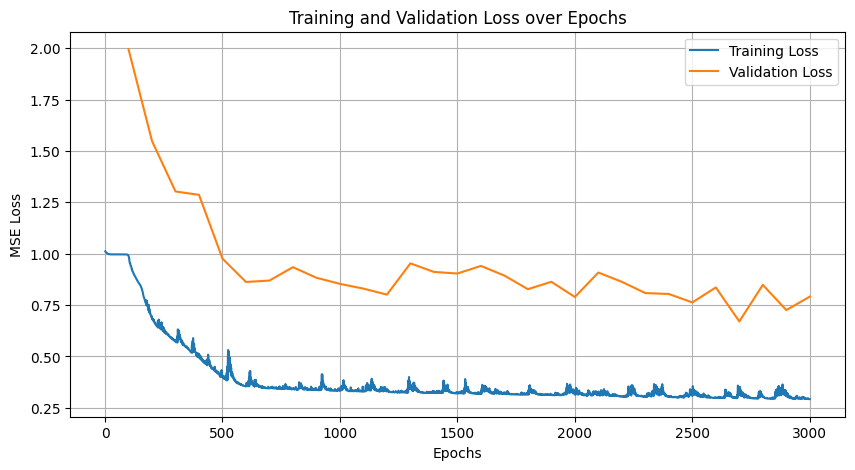

[I 2024-11-13 22:07:02,421] Trial 0 finished with value: 0.7909058928489685 and parameters: {'lr': 0.0018849745624366675, 'num_layers': 16, 'hidden_size': 18}. Best is trial 0 with value: 0.7909058928489685.


Learning Rate:  0.004046360898528275


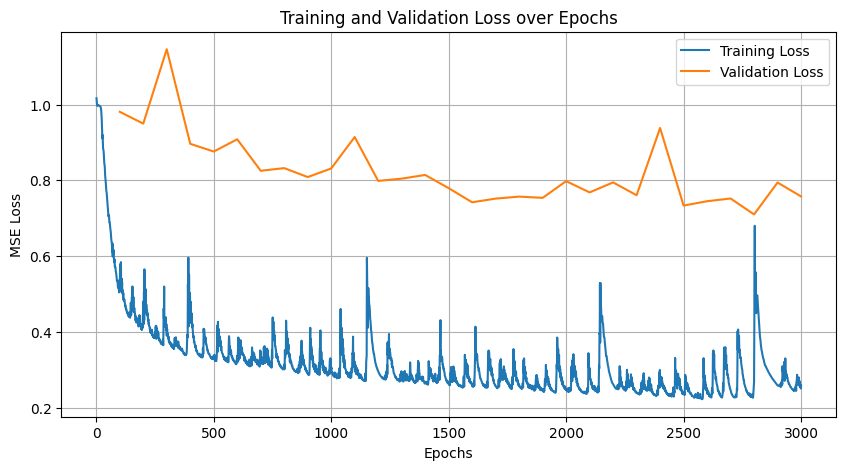

[I 2024-11-13 22:11:35,891] Trial 1 finished with value: 0.7573798298835754 and parameters: {'lr': 0.004046360898528275, 'num_layers': 13, 'hidden_size': 28}. Best is trial 1 with value: 0.7573798298835754.


Learning Rate:  0.008736754885276818


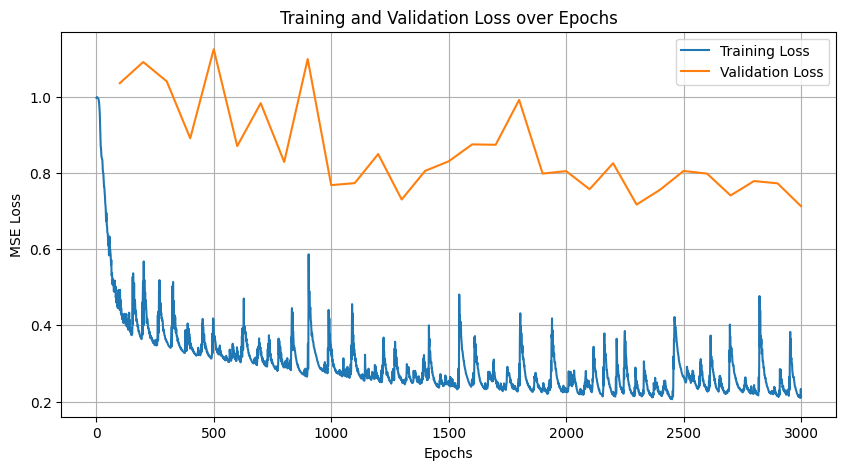

[I 2024-11-13 22:14:08,367] Trial 2 finished with value: 0.7122228145599365 and parameters: {'lr': 0.008736754885276818, 'num_layers': 10, 'hidden_size': 22}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.0008420161721517181


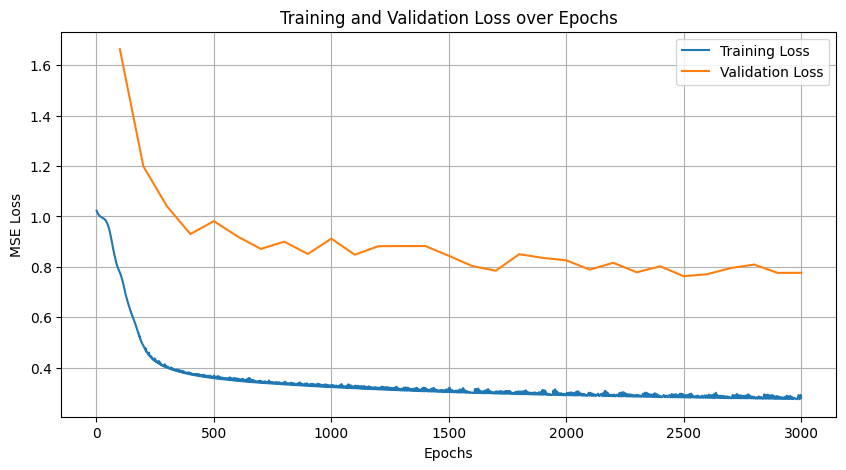

[I 2024-11-13 22:16:37,025] Trial 3 finished with value: 0.7762540578842163 and parameters: {'lr': 0.0008420161721517181, 'num_layers': 7, 'hidden_size': 30}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.0019497215229191621


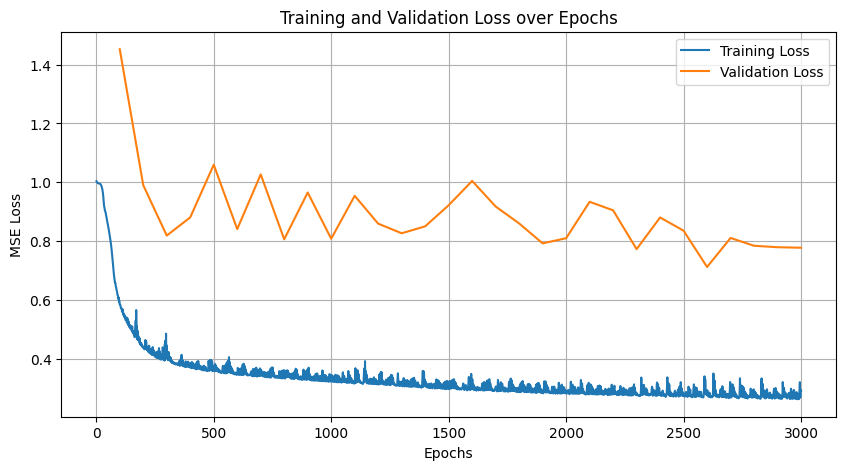

[I 2024-11-13 22:19:49,300] Trial 4 finished with value: 0.7773621082305908 and parameters: {'lr': 0.0019497215229191621, 'num_layers': 10, 'hidden_size': 28}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.0067269107420364115


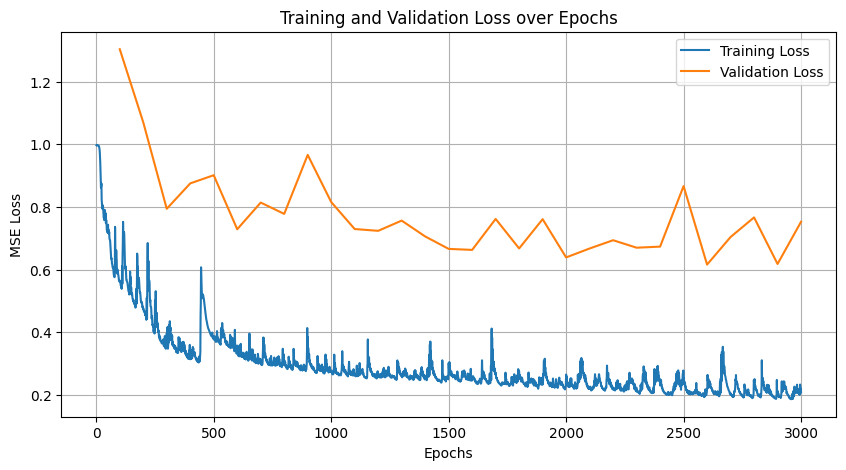

[I 2024-11-13 22:23:55,644] Trial 5 finished with value: 0.7526711821556091 and parameters: {'lr': 0.0067269107420364115, 'num_layers': 12, 'hidden_size': 29}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.00024217551960945466


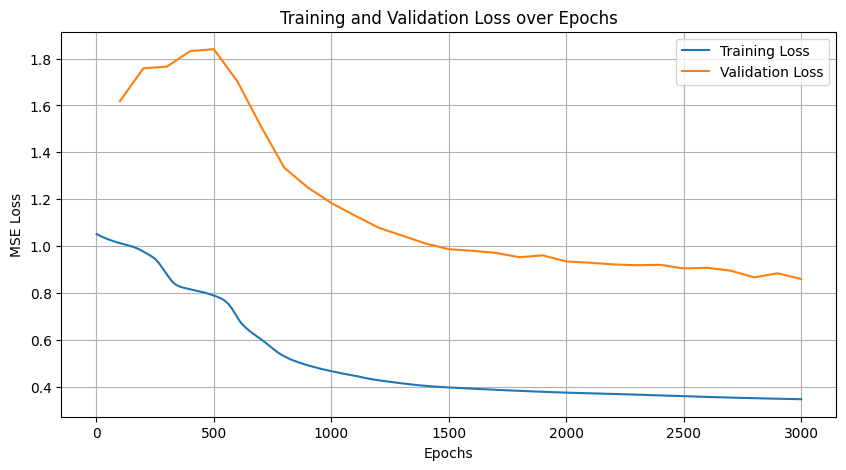

[I 2024-11-13 22:25:01,009] Trial 6 finished with value: 0.8590508103370667 and parameters: {'lr': 0.00024217551960945466, 'num_layers': 7, 'hidden_size': 14}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.008887250576889057


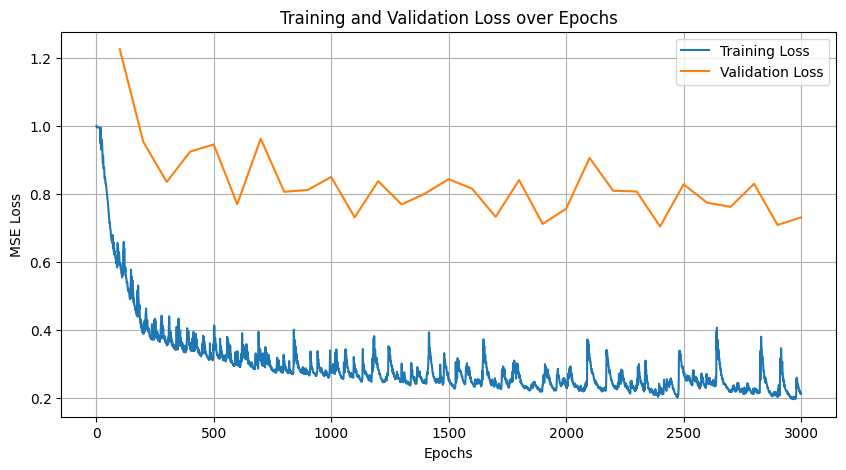

[I 2024-11-13 22:28:50,654] Trial 7 finished with value: 0.7315483689308167 and parameters: {'lr': 0.008887250576889057, 'num_layers': 13, 'hidden_size': 26}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.00014797295393499947


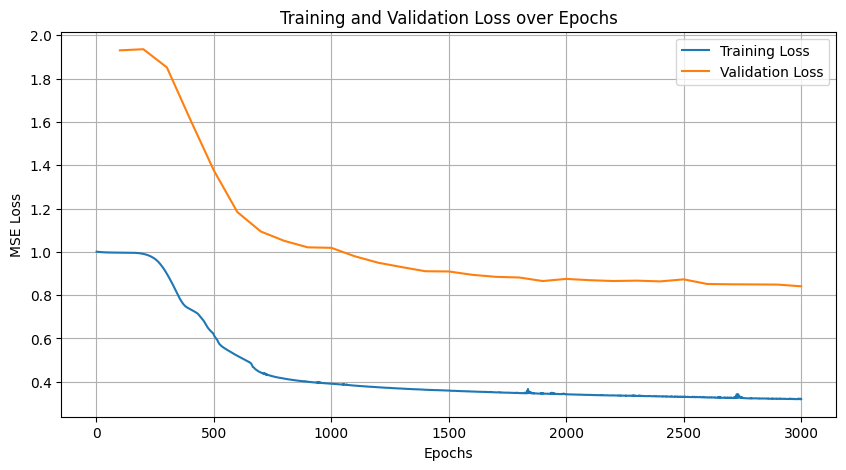

[I 2024-11-13 22:31:52,567] Trial 8 finished with value: 0.8406702876091003 and parameters: {'lr': 0.00014797295393499947, 'num_layers': 12, 'hidden_size': 22}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.0008580451389982378


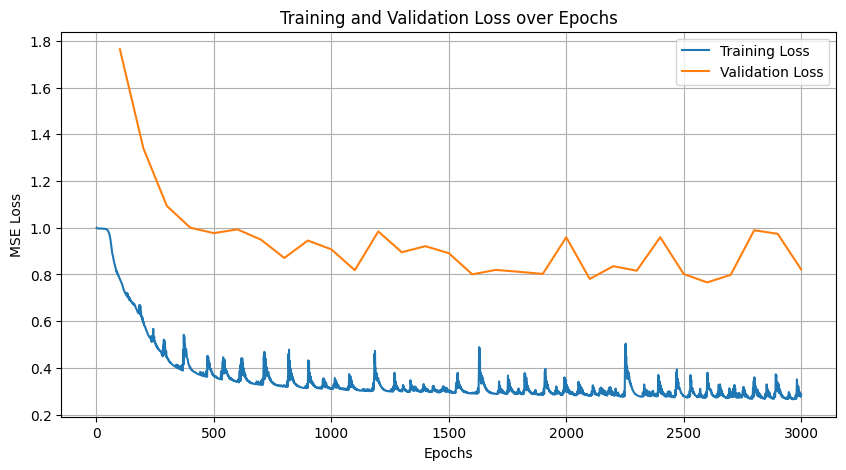

[I 2024-11-13 22:36:38,160] Trial 9 finished with value: 0.8212049007415771 and parameters: {'lr': 0.0008580451389982378, 'num_layers': 14, 'hidden_size': 29}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.00038131774834310845


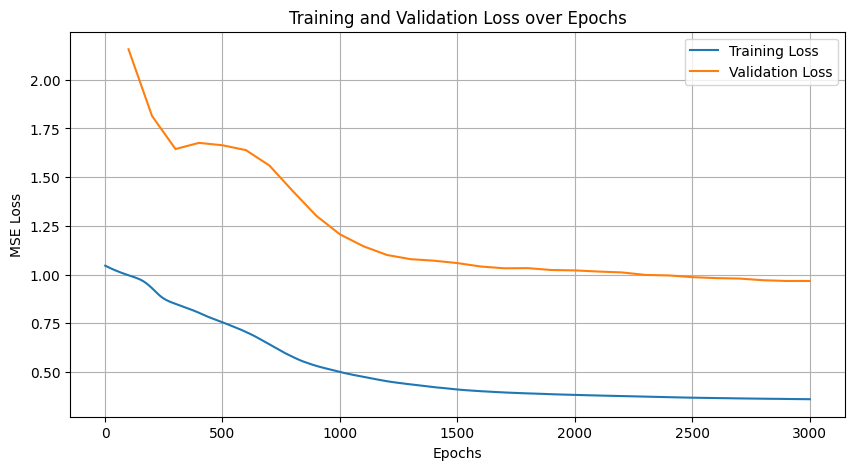

[I 2024-11-13 22:37:15,210] Trial 10 finished with value: 0.966915488243103 and parameters: {'lr': 0.00038131774834310845, 'num_layers': 5, 'hidden_size': 11}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.009567342810060477


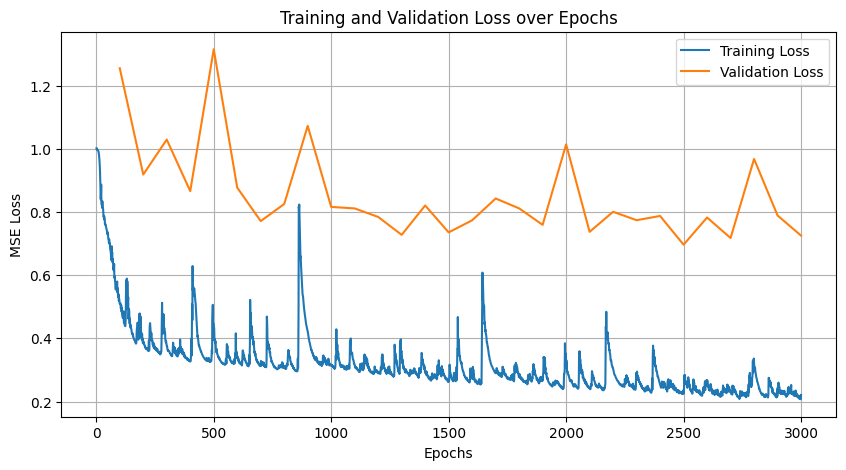

[I 2024-11-13 22:39:57,978] Trial 11 finished with value: 0.7250354290008545 and parameters: {'lr': 0.009567342810060477, 'num_layers': 10, 'hidden_size': 23}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.003977135867951367


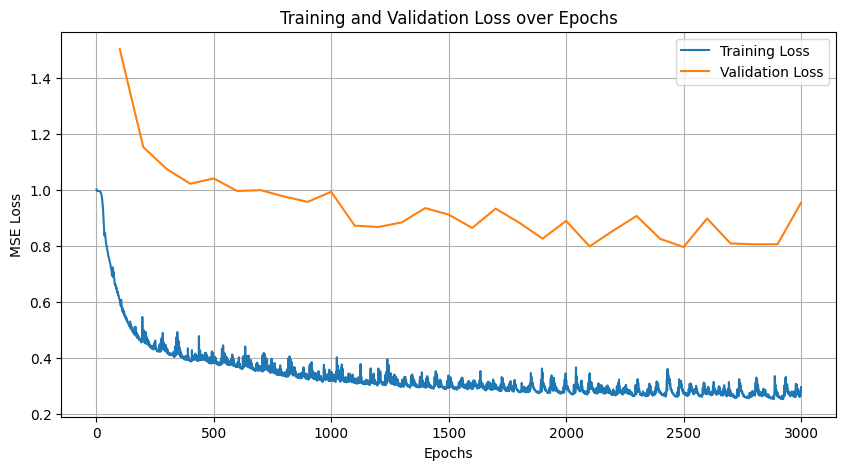

[I 2024-11-13 22:42:23,055] Trial 12 finished with value: 0.9546694159507751 and parameters: {'lr': 0.003977135867951367, 'num_layers': 9, 'hidden_size': 23}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.009205780362563911


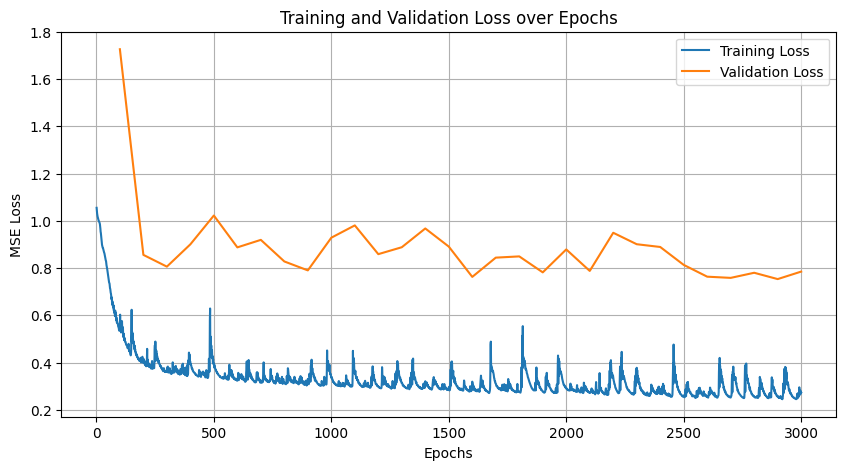

[I 2024-11-13 22:44:16,649] Trial 13 finished with value: 0.7851000428199768 and parameters: {'lr': 0.009205780362563911, 'num_layers': 9, 'hidden_size': 19}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.0038877512811831072


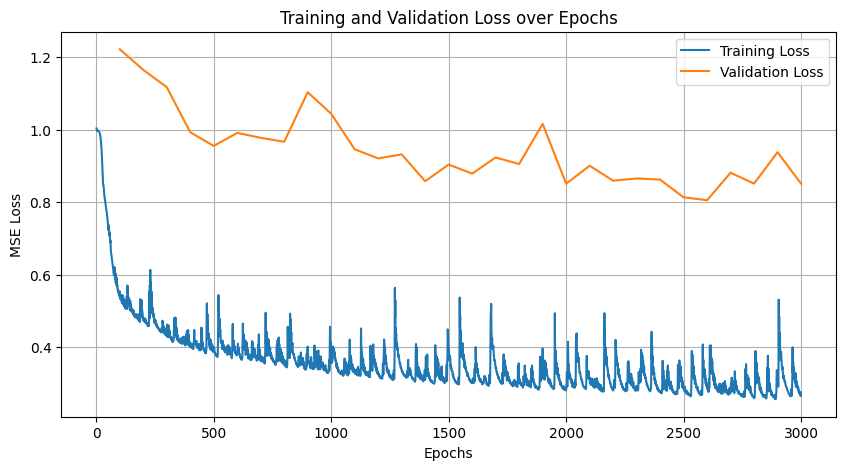

[I 2024-11-13 22:46:32,226] Trial 14 finished with value: 0.8510404229164124 and parameters: {'lr': 0.0038877512811831072, 'num_layers': 10, 'hidden_size': 24}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.00200607022893563


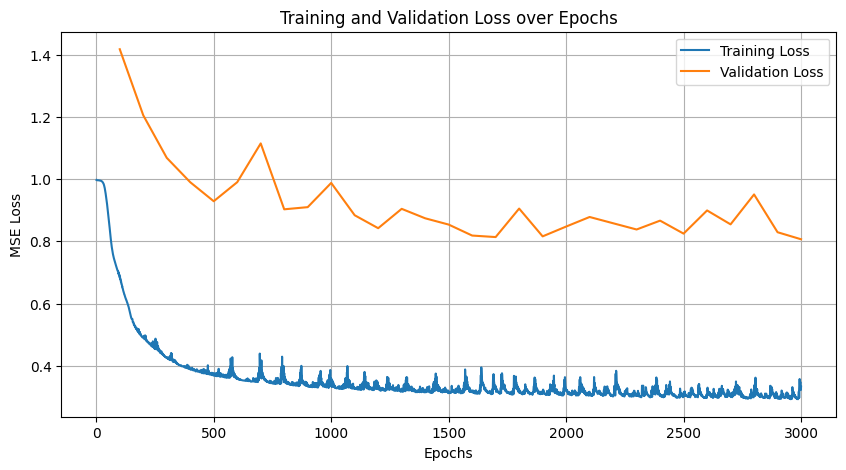

[I 2024-11-13 22:47:48,590] Trial 15 finished with value: 0.8066897392272949 and parameters: {'lr': 0.00200607022893563, 'num_layers': 7, 'hidden_size': 17}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.005180946055470304


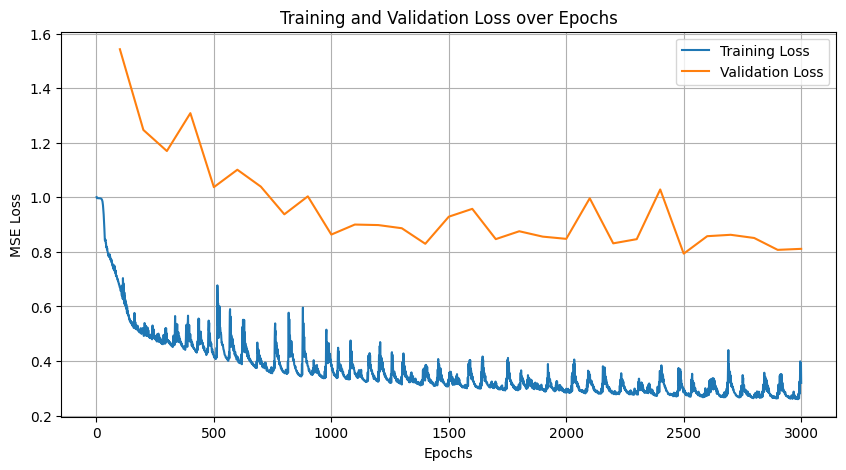

[I 2024-11-13 22:50:17,693] Trial 16 finished with value: 0.8110769987106323 and parameters: {'lr': 0.005180946055470304, 'num_layers': 11, 'hidden_size': 20}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.0026194826571537687


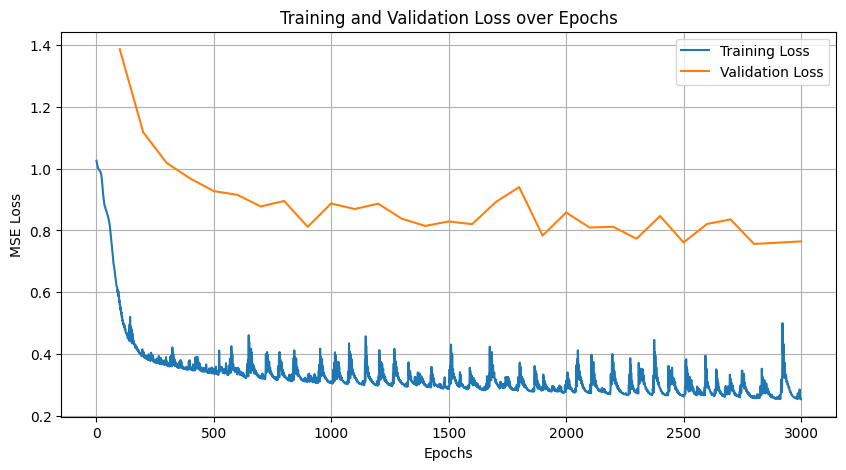

[I 2024-11-13 22:52:31,973] Trial 17 finished with value: 0.7647096514701843 and parameters: {'lr': 0.0026194826571537687, 'num_layers': 8, 'hidden_size': 25}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.0005408994962145833


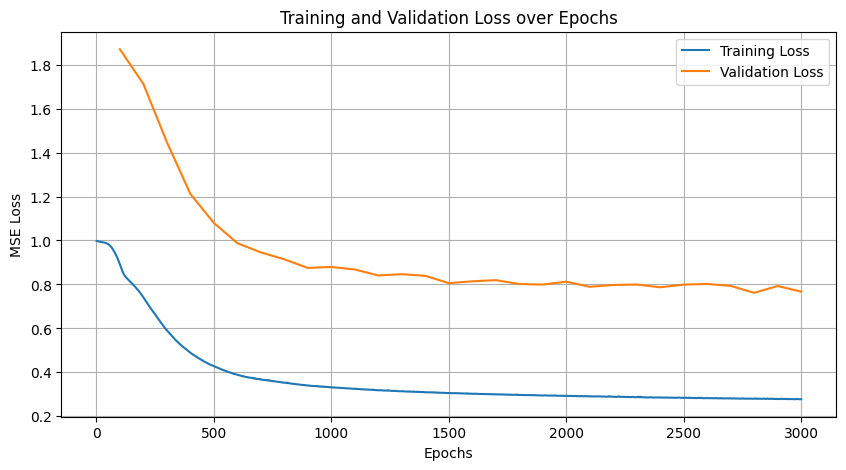

[I 2024-11-13 22:53:41,672] Trial 18 finished with value: 0.7672665119171143 and parameters: {'lr': 0.0005408994962145833, 'num_layers': 5, 'hidden_size': 21}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.009727608205334368


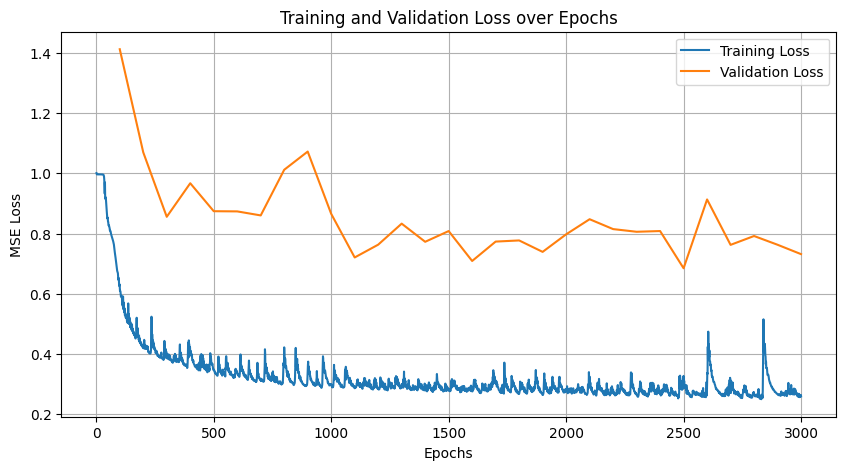

[I 2024-11-13 22:55:35,361] Trial 19 finished with value: 0.7314269542694092 and parameters: {'lr': 0.009727608205334368, 'num_layers': 15, 'hidden_size': 16}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.005987995744909831


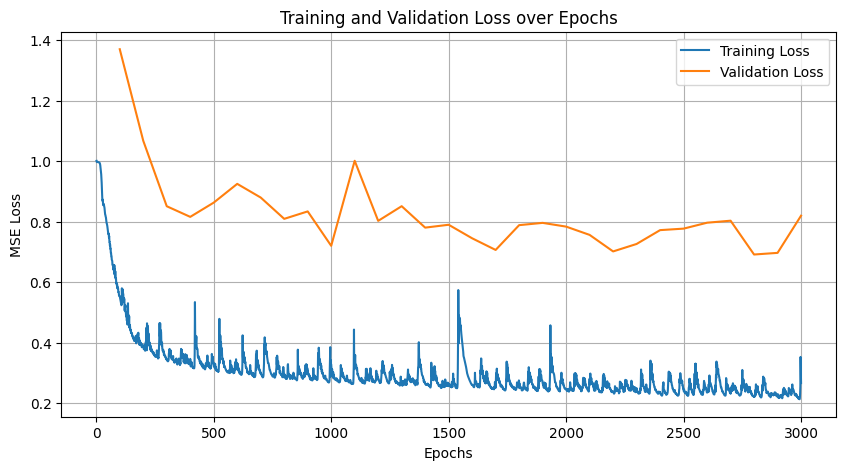

[I 2024-11-13 22:58:54,388] Trial 20 finished with value: 0.819398045539856 and parameters: {'lr': 0.005987995744909831, 'num_layers': 11, 'hidden_size': 26}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.008100484493683106


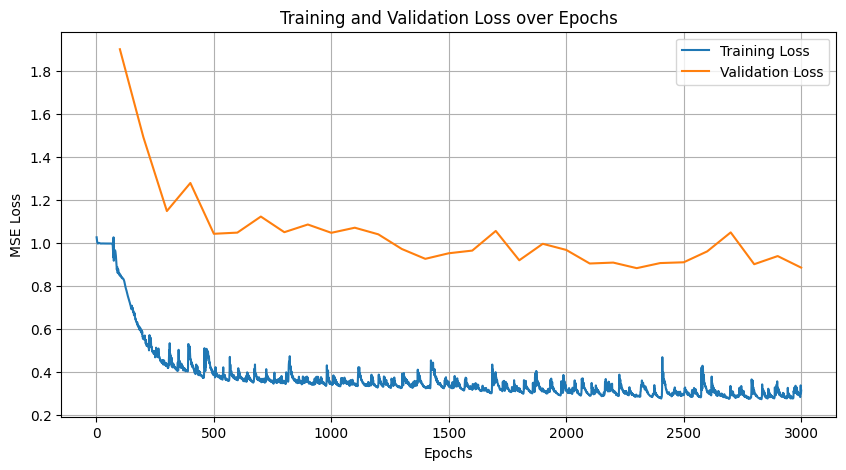

[I 2024-11-13 23:01:38,211] Trial 21 finished with value: 0.8843510746955872 and parameters: {'lr': 0.008100484493683106, 'num_layers': 16, 'hidden_size': 15}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.00969759302365125


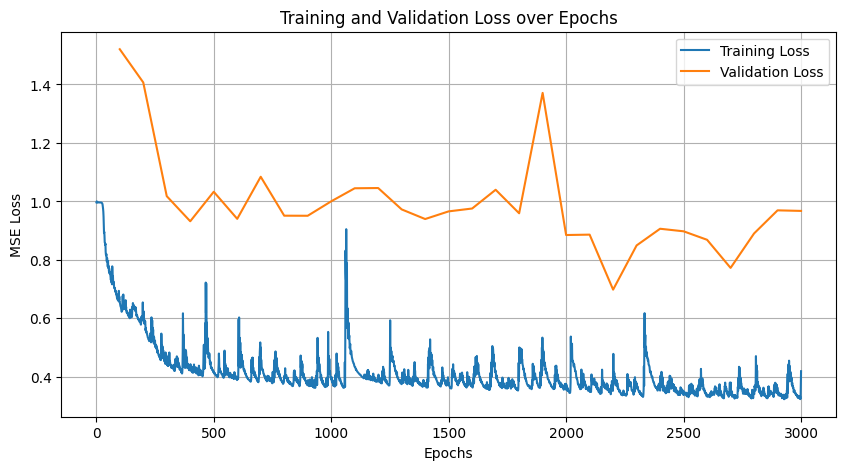

[I 2024-11-13 23:03:29,311] Trial 22 finished with value: 0.967464804649353 and parameters: {'lr': 0.00969759302365125, 'num_layers': 15, 'hidden_size': 16}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.002908685893116341


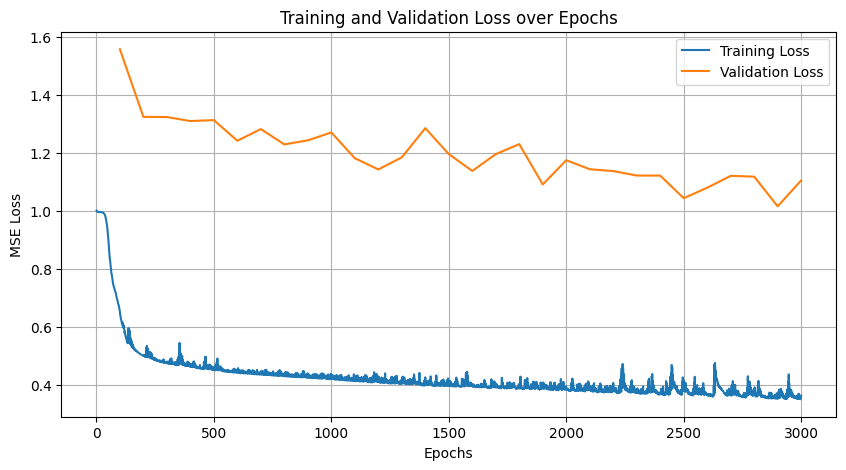

[I 2024-11-13 23:04:45,835] Trial 23 finished with value: 1.1054911613464355 and parameters: {'lr': 0.002908685893116341, 'num_layers': 9, 'hidden_size': 13}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.0013428678599196745


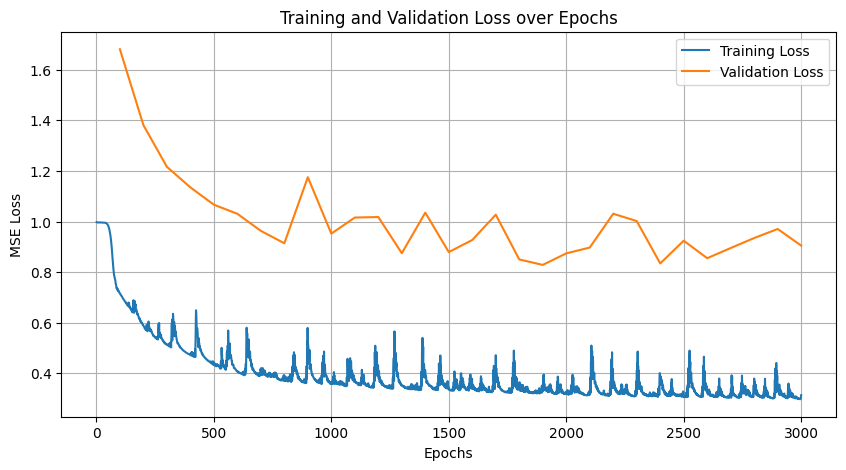

[I 2024-11-13 23:07:47,025] Trial 24 finished with value: 0.9050024747848511 and parameters: {'lr': 0.0013428678599196745, 'num_layers': 12, 'hidden_size': 22}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.005407845359046732


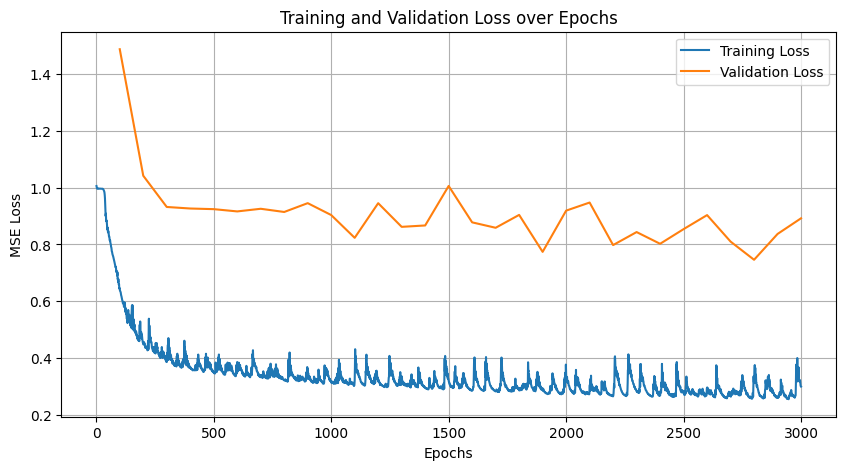

[I 2024-11-13 23:10:54,625] Trial 25 finished with value: 0.8923330903053284 and parameters: {'lr': 0.005407845359046732, 'num_layers': 14, 'hidden_size': 20}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.00582975451664895


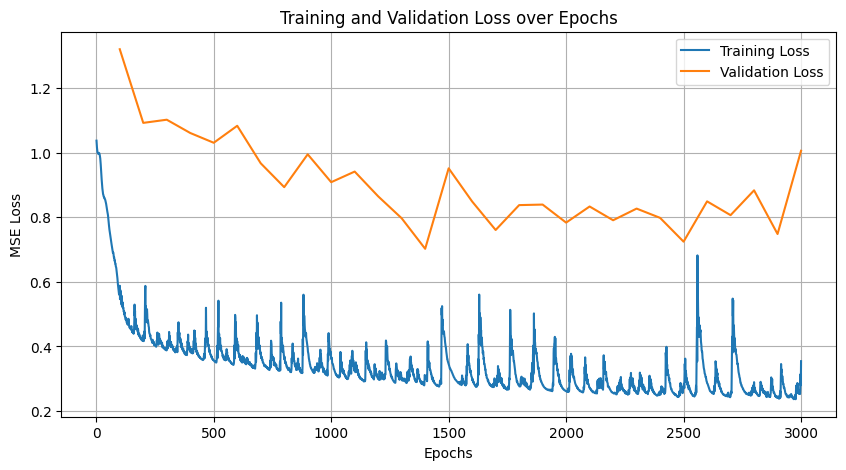

[I 2024-11-13 23:12:59,232] Trial 26 finished with value: 1.0053669214248657 and parameters: {'lr': 0.00582975451664895, 'num_layers': 10, 'hidden_size': 19}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.003070139341105903


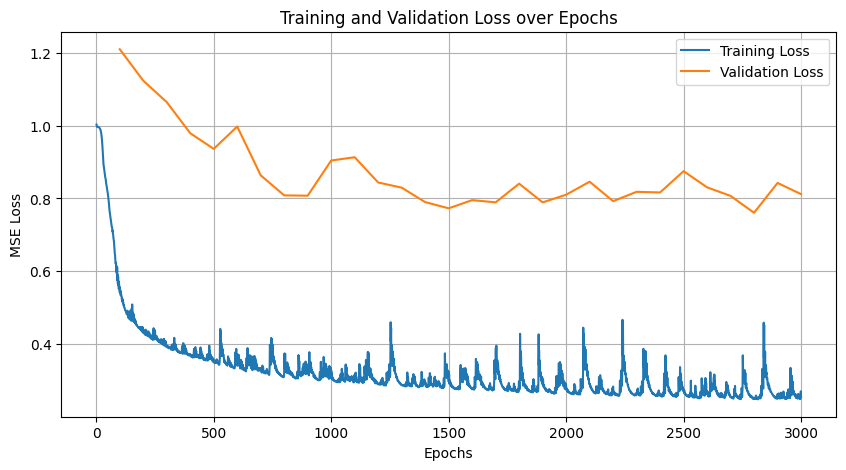

[I 2024-11-13 23:15:06,764] Trial 27 finished with value: 0.8118289709091187 and parameters: {'lr': 0.003070139341105903, 'num_layers': 8, 'hidden_size': 23}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.00718433286688305


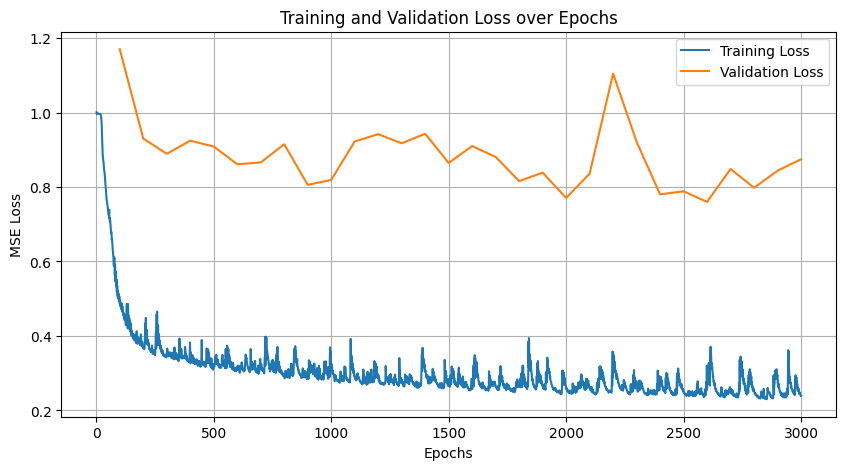

[I 2024-11-13 23:17:11,819] Trial 28 finished with value: 0.874451756477356 and parameters: {'lr': 0.00718433286688305, 'num_layers': 11, 'hidden_size': 18}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.00011179834376814191


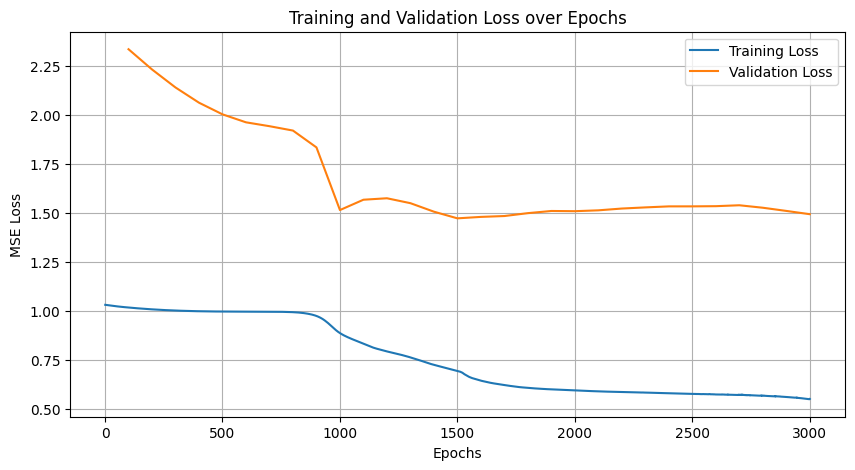

[I 2024-11-13 23:19:05,075] Trial 29 finished with value: 1.4935060739517212 and parameters: {'lr': 0.00011179834376814191, 'num_layers': 15, 'hidden_size': 12}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.0011795190954745625


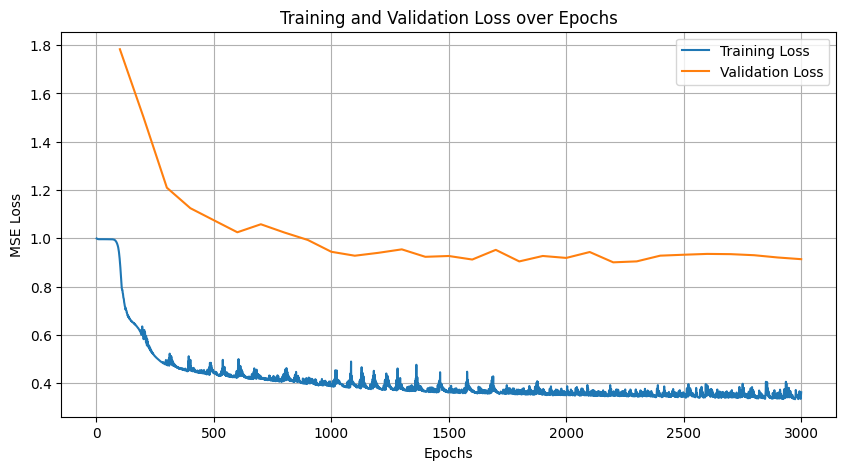

[I 2024-11-13 23:21:55,551] Trial 30 finished with value: 0.9138925671577454 and parameters: {'lr': 0.0011795190954745625, 'num_layers': 16, 'hidden_size': 17}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.009857891051316214


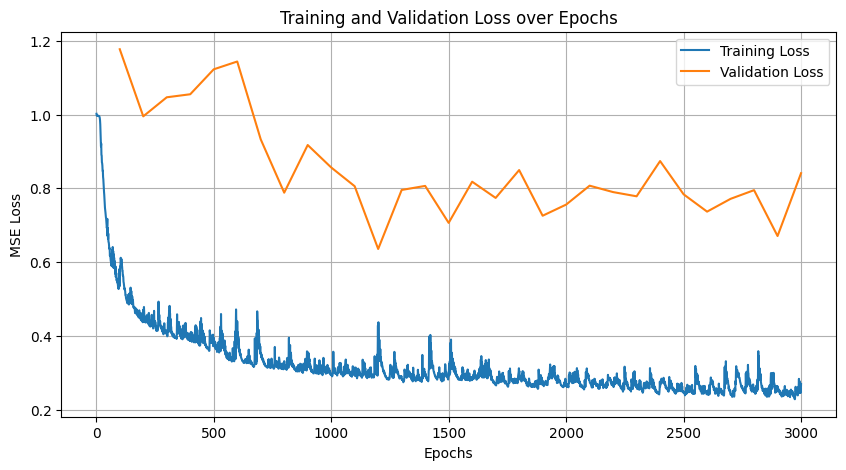

[I 2024-11-13 23:25:41,875] Trial 31 finished with value: 0.8411561250686646 and parameters: {'lr': 0.009857891051316214, 'num_layers': 13, 'hidden_size': 26}. Best is trial 2 with value: 0.7122228145599365.


Learning Rate:  0.004608911641116631


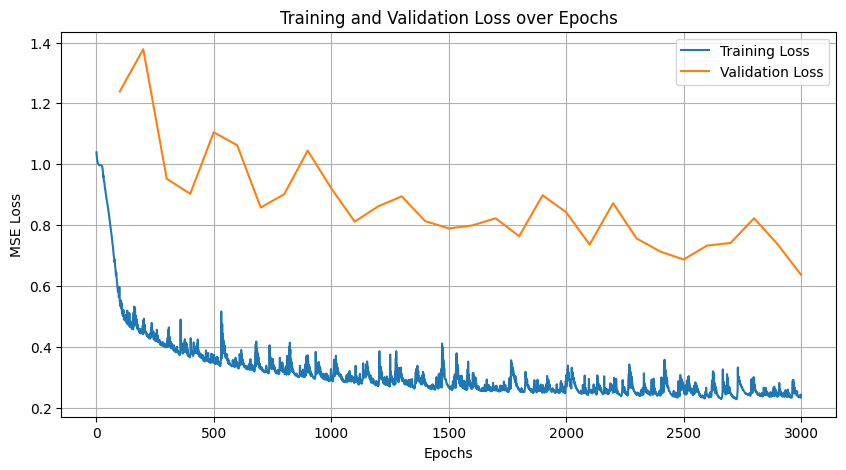

[I 2024-11-13 23:29:48,900] Trial 32 finished with value: 0.6362831592559814 and parameters: {'lr': 0.004608911641116631, 'num_layers': 14, 'hidden_size': 26}. Best is trial 32 with value: 0.6362831592559814.


Learning Rate:  0.0045900793572596545


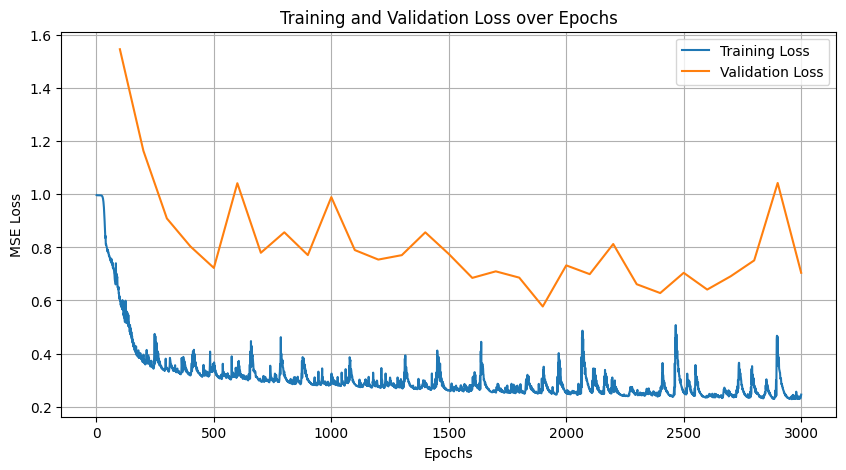

[I 2024-11-13 23:33:12,510] Trial 33 finished with value: 0.7043863534927368 and parameters: {'lr': 0.0045900793572596545, 'num_layers': 15, 'hidden_size': 24}. Best is trial 32 with value: 0.6362831592559814.


Learning Rate:  0.0045736297411635455


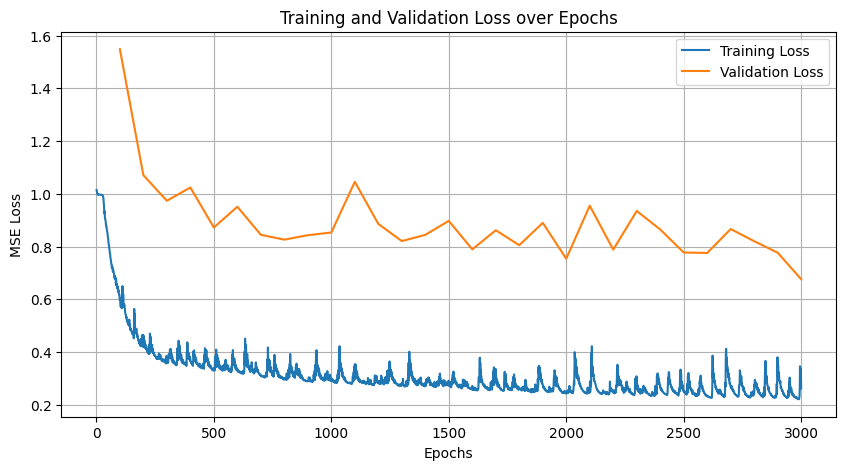

[I 2024-11-13 23:36:21,416] Trial 34 finished with value: 0.6761161684989929 and parameters: {'lr': 0.0045736297411635455, 'num_layers': 14, 'hidden_size': 24}. Best is trial 32 with value: 0.6362831592559814.


Learning Rate:  0.0038479364881456113


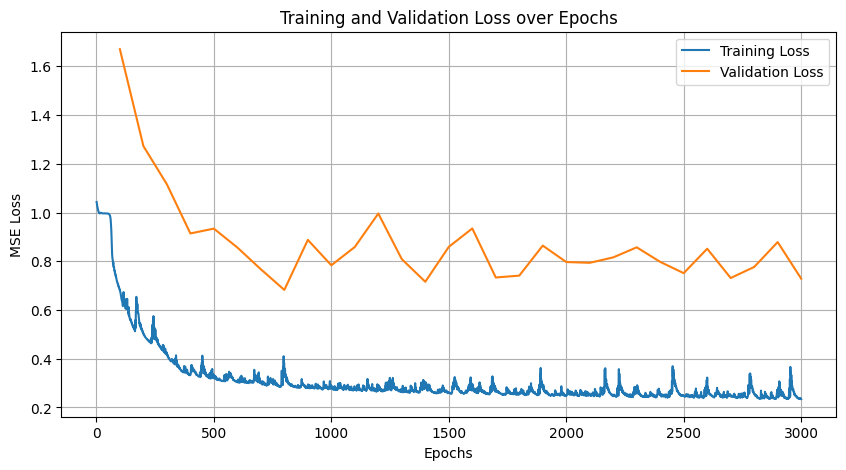

[I 2024-11-13 23:40:15,799] Trial 35 finished with value: 0.7287123203277588 and parameters: {'lr': 0.0038479364881456113, 'num_layers': 14, 'hidden_size': 25}. Best is trial 32 with value: 0.6362831592559814.


Learning Rate:  0.002239475742253304


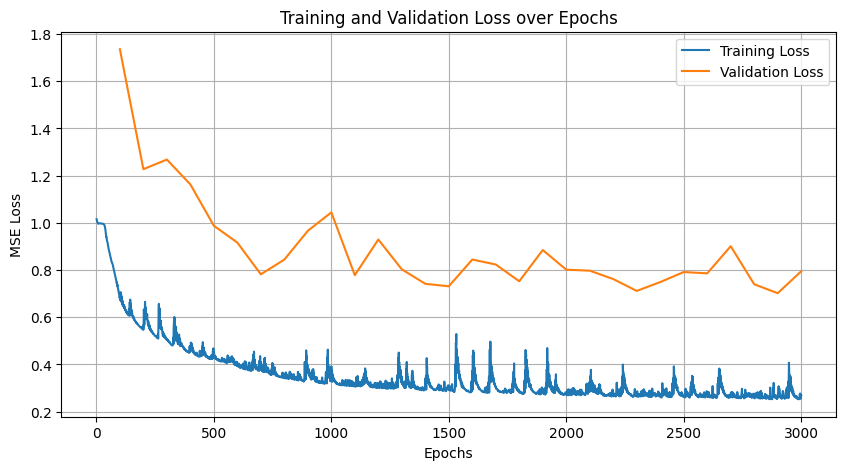

[I 2024-11-13 23:44:16,426] Trial 36 finished with value: 0.7946392297744751 and parameters: {'lr': 0.002239475742253304, 'num_layers': 13, 'hidden_size': 27}. Best is trial 32 with value: 0.6362831592559814.


Learning Rate:  0.004814393144968446


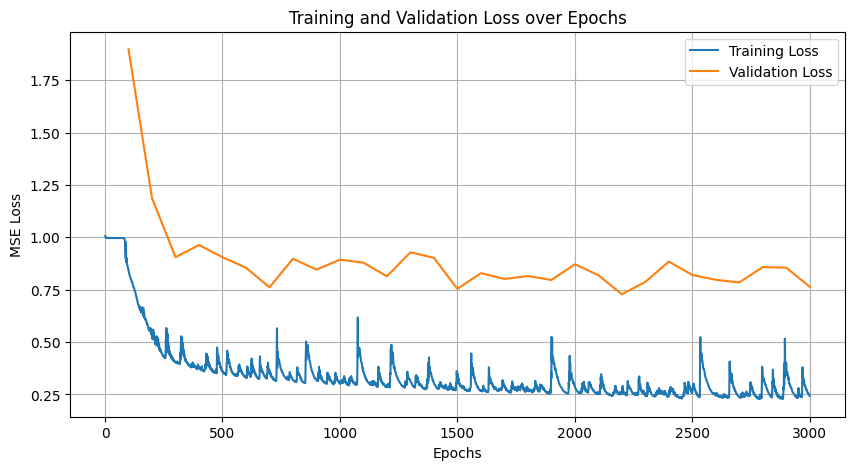

[I 2024-11-13 23:47:53,388] Trial 37 finished with value: 0.7635646462440491 and parameters: {'lr': 0.004814393144968446, 'num_layers': 16, 'hidden_size': 24}. Best is trial 32 with value: 0.6362831592559814.


Learning Rate:  0.0015002997436660784


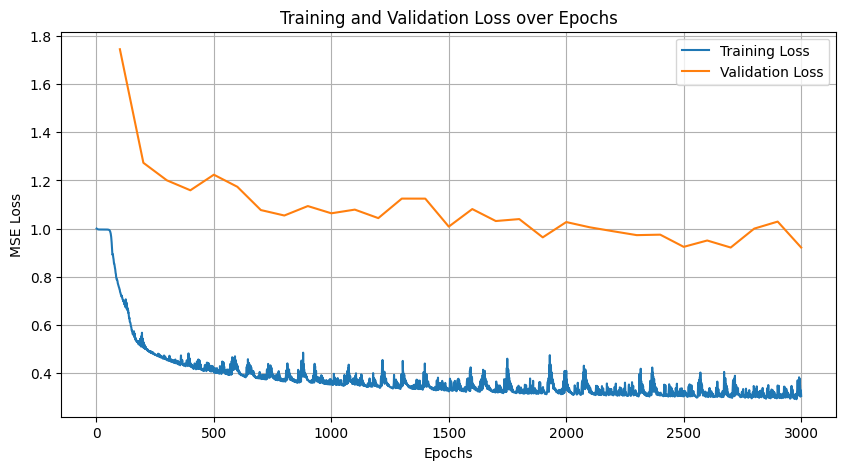

[I 2024-11-13 23:52:14,656] Trial 38 finished with value: 0.9216746687889099 and parameters: {'lr': 0.0015002997436660784, 'num_layers': 14, 'hidden_size': 28}. Best is trial 32 with value: 0.6362831592559814.


Learning Rate:  0.0032553167952876975


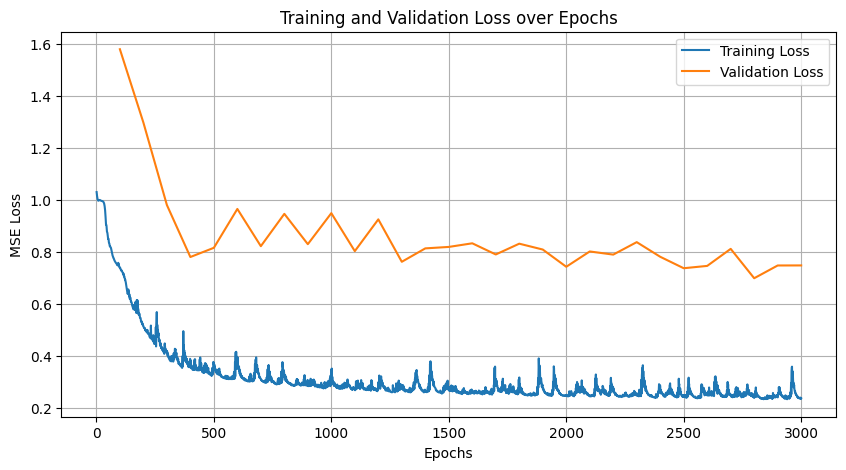

[I 2024-11-13 23:55:02,931] Trial 39 finished with value: 0.7480266094207764 and parameters: {'lr': 0.0032553167952876975, 'num_layers': 12, 'hidden_size': 21}. Best is trial 32 with value: 0.6362831592559814.


Learning Rate:  0.0070188909457611585


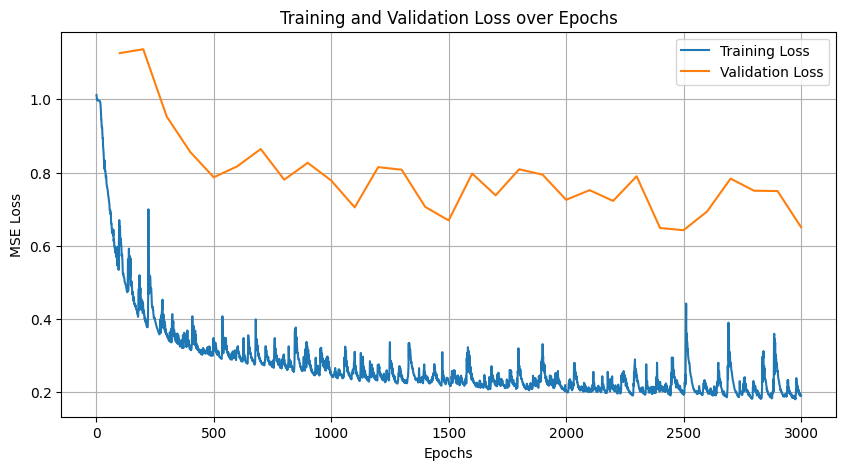

[I 2024-11-13 23:59:03,075] Trial 40 finished with value: 0.65073561668396 and parameters: {'lr': 0.0070188909457611585, 'num_layers': 13, 'hidden_size': 27}. Best is trial 32 with value: 0.6362831592559814.


Learning Rate:  0.007218215485898306


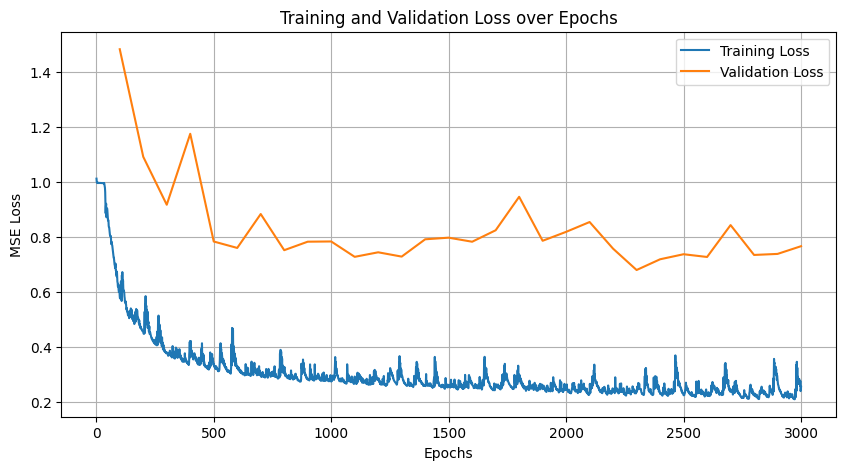

[I 2024-11-14 00:03:51,246] Trial 41 finished with value: 0.7671513557434082 and parameters: {'lr': 0.007218215485898306, 'num_layers': 15, 'hidden_size': 28}. Best is trial 32 with value: 0.6362831592559814.


Learning Rate:  0.00455691044155973


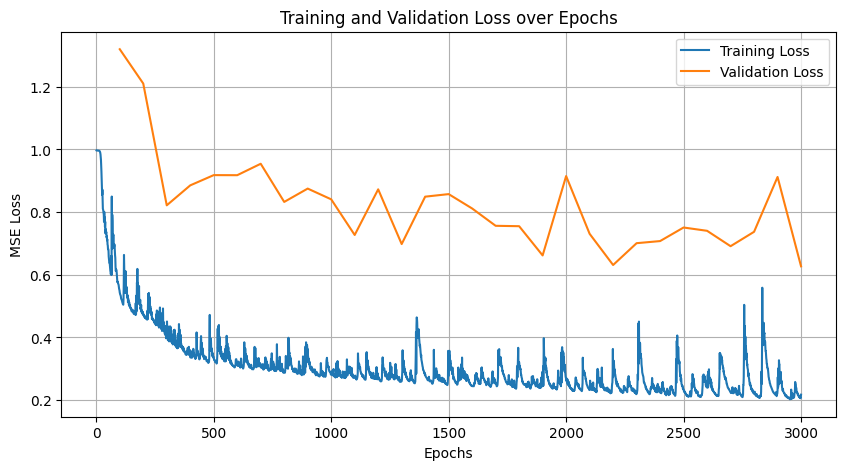

[I 2024-11-14 00:08:28,012] Trial 42 finished with value: 0.6270062327384949 and parameters: {'lr': 0.00455691044155973, 'num_layers': 13, 'hidden_size': 30}. Best is trial 42 with value: 0.6270062327384949.


Learning Rate:  0.00476167903021962


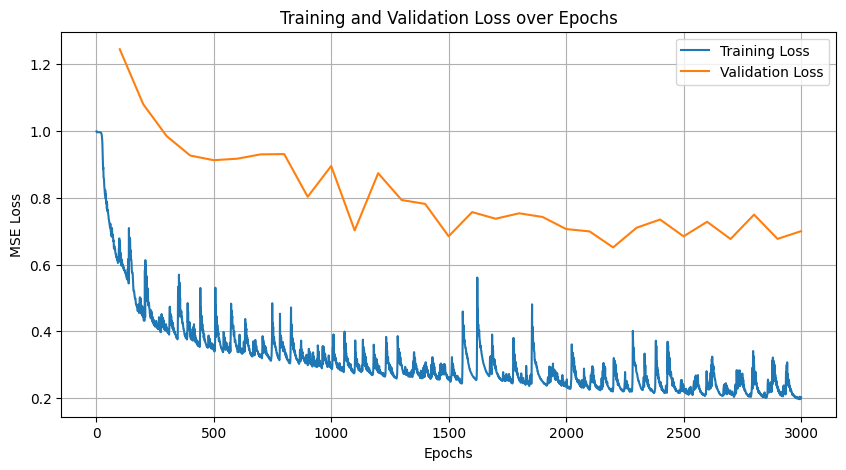

[I 2024-11-14 00:12:53,895] Trial 43 finished with value: 0.7002021670341492 and parameters: {'lr': 0.00476167903021962, 'num_layers': 13, 'hidden_size': 29}. Best is trial 42 with value: 0.6270062327384949.


Learning Rate:  0.0016382826285643568


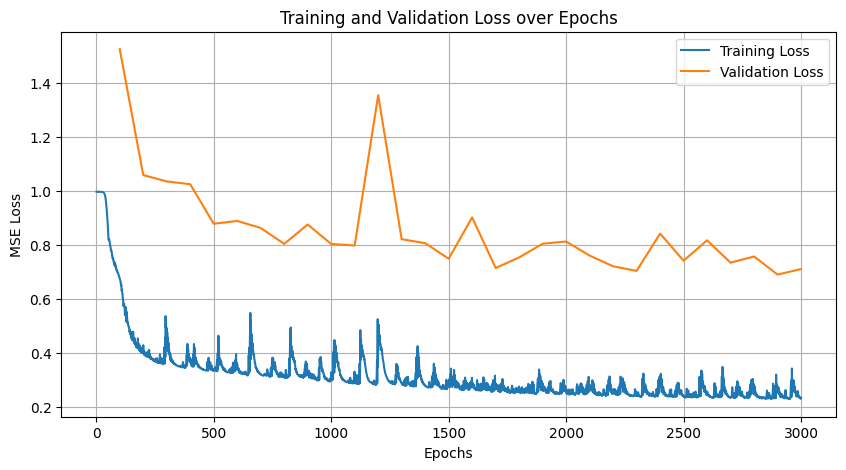

[I 2024-11-14 00:17:31,017] Trial 44 finished with value: 0.7106293439865112 and parameters: {'lr': 0.0016382826285643568, 'num_layers': 13, 'hidden_size': 30}. Best is trial 42 with value: 0.6270062327384949.


Learning Rate:  0.002317776960943391


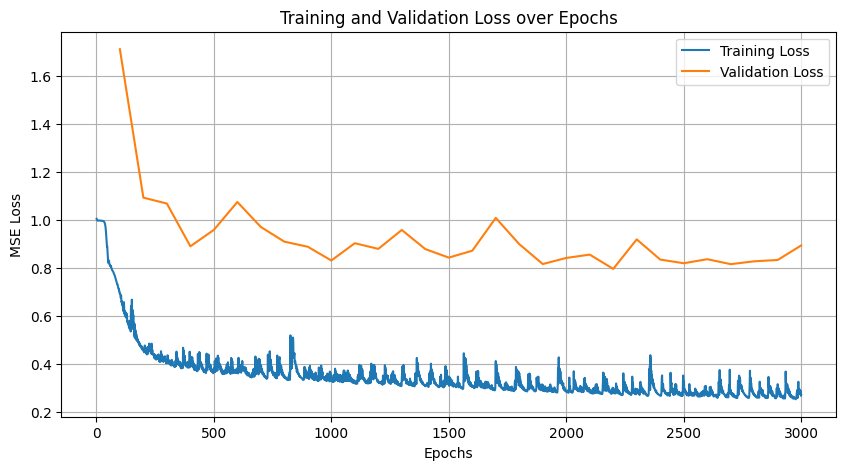

[I 2024-11-14 00:22:08,156] Trial 45 finished with value: 0.8935046792030334 and parameters: {'lr': 0.002317776960943391, 'num_layers': 13, 'hidden_size': 30}. Best is trial 42 with value: 0.6270062327384949.


Learning Rate:  0.0033941458095643733


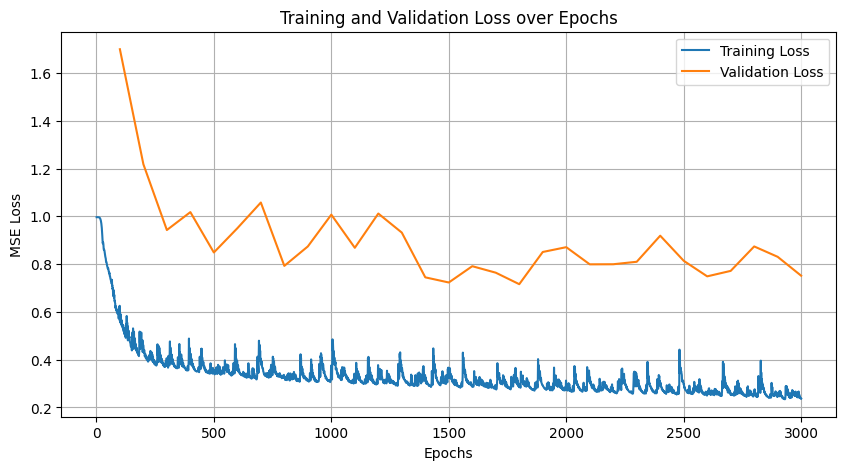

[I 2024-11-14 00:26:55,975] Trial 46 finished with value: 0.7513830065727234 and parameters: {'lr': 0.0033941458095643733, 'num_layers': 14, 'hidden_size': 29}. Best is trial 42 with value: 0.6270062327384949.


Learning Rate:  0.006611305920787636


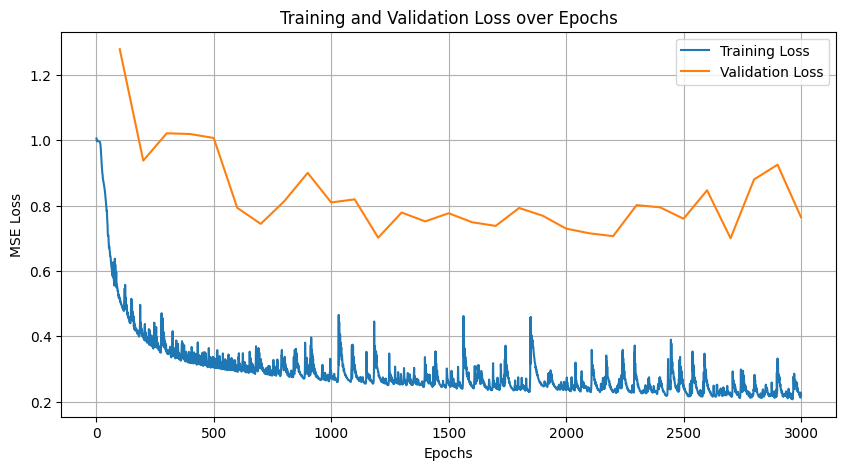

[I 2024-11-14 00:30:39,801] Trial 47 finished with value: 0.7638244032859802 and parameters: {'lr': 0.006611305920787636, 'num_layers': 12, 'hidden_size': 27}. Best is trial 42 with value: 0.6270062327384949.


Learning Rate:  0.004339248248839737


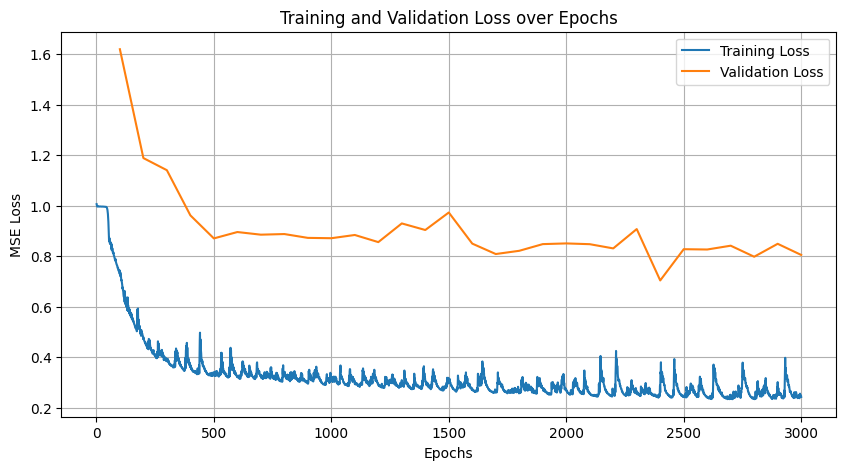

[I 2024-11-14 00:34:59,771] Trial 48 finished with value: 0.8049041628837585 and parameters: {'lr': 0.004339248248839737, 'num_layers': 14, 'hidden_size': 27}. Best is trial 42 with value: 0.6270062327384949.


Learning Rate:  0.002569422734166334


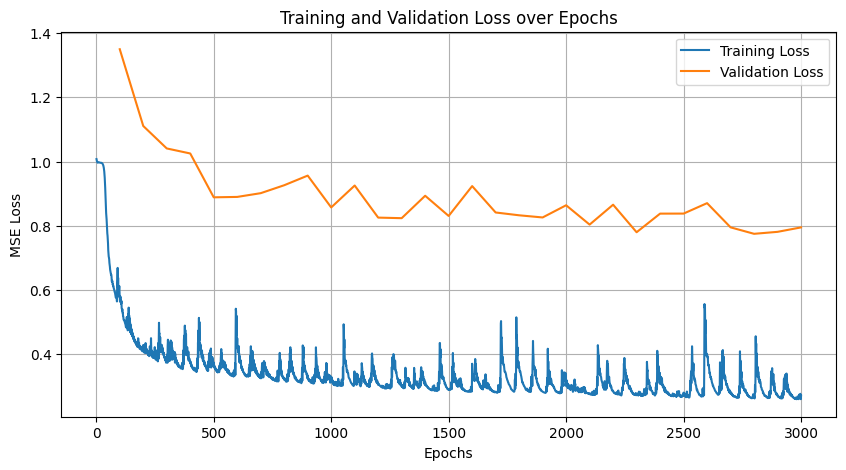

[I 2024-11-14 00:39:01,925] Trial 49 finished with value: 0.7947185635566711 and parameters: {'lr': 0.002569422734166334, 'num_layers': 12, 'hidden_size': 29}. Best is trial 42 with value: 0.6270062327384949.


Learning Rate:  0.0005693716984187507


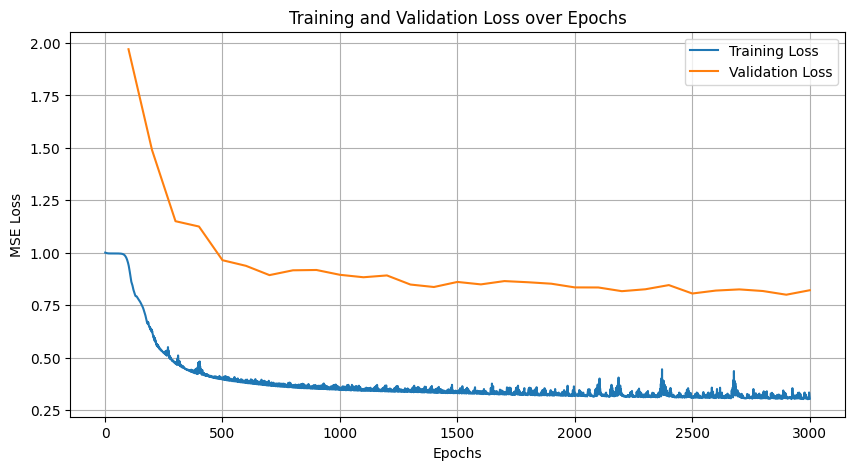

[I 2024-11-14 00:43:03,211] Trial 50 finished with value: 0.821049690246582 and parameters: {'lr': 0.0005693716984187507, 'num_layers': 13, 'hidden_size': 28}. Best is trial 42 with value: 0.6270062327384949.


Learning Rate:  0.004662180008744913


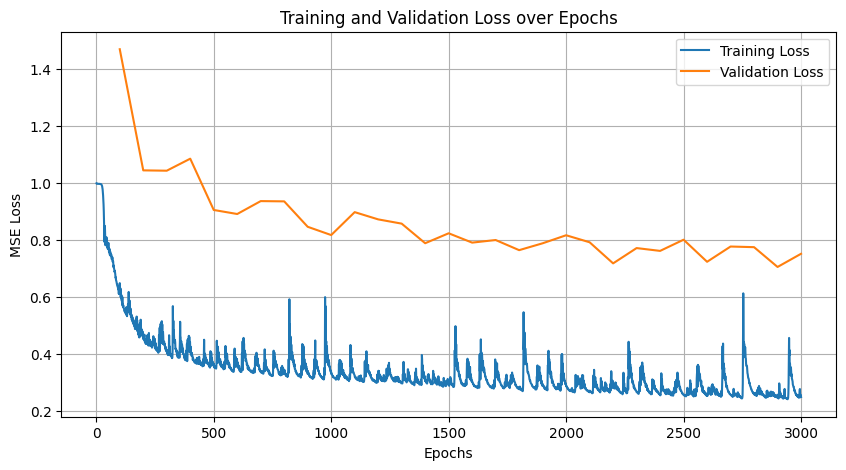

[I 2024-11-14 00:47:29,074] Trial 51 finished with value: 0.7509011030197144 and parameters: {'lr': 0.004662180008744913, 'num_layers': 15, 'hidden_size': 26}. Best is trial 42 with value: 0.6270062327384949.


Learning Rate:  0.0037522328624942643


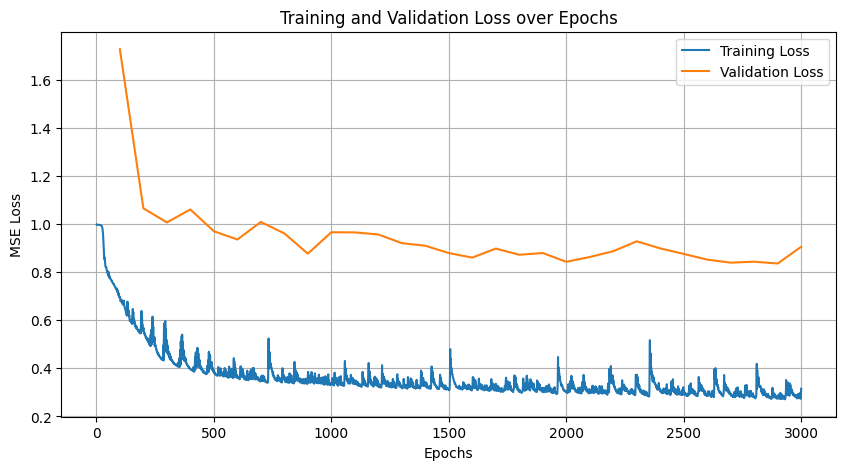

[I 2024-11-14 00:51:53,125] Trial 52 finished with value: 0.9053643941879272 and parameters: {'lr': 0.0037522328624942643, 'num_layers': 14, 'hidden_size': 25}. Best is trial 42 with value: 0.6270062327384949.


Learning Rate:  0.005316163675097679


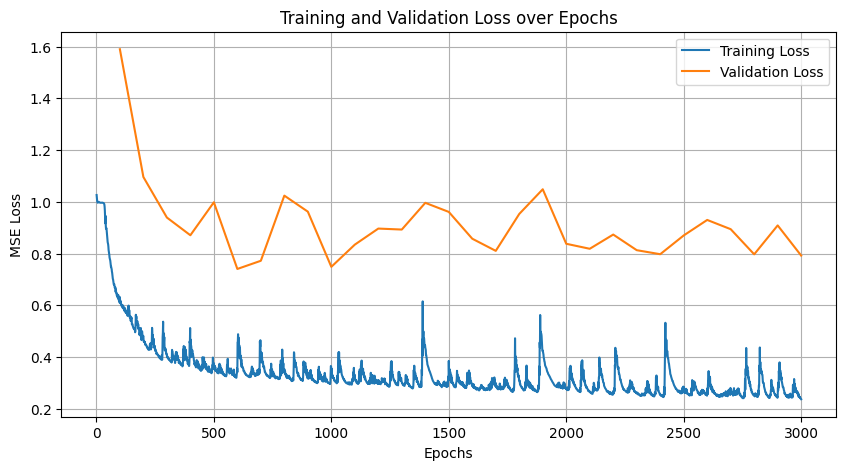

[I 2024-11-14 00:55:07,001] Trial 53 finished with value: 0.7921721339225769 and parameters: {'lr': 0.005316163675097679, 'num_layers': 15, 'hidden_size': 24}. Best is trial 42 with value: 0.6270062327384949.


Learning Rate:  0.007782740746537051


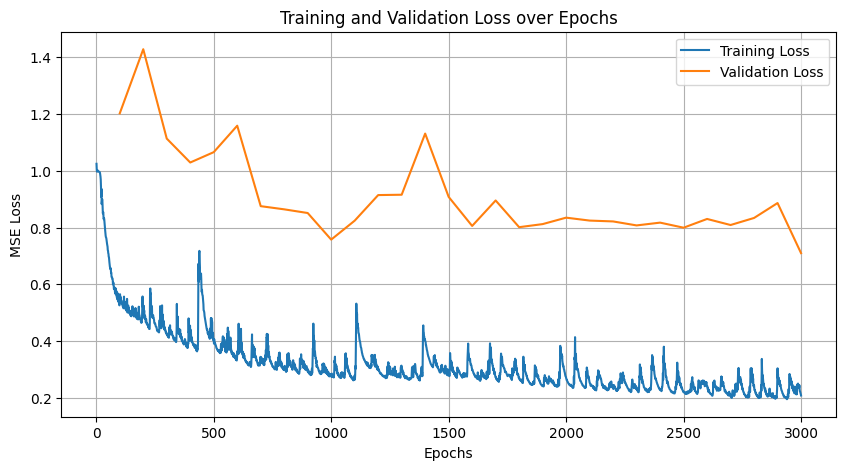

[I 2024-11-14 00:59:22,830] Trial 54 finished with value: 0.709908127784729 and parameters: {'lr': 0.007782740746537051, 'num_layers': 13, 'hidden_size': 29}. Best is trial 42 with value: 0.6270062327384949.


Learning Rate:  0.0062636891190876965


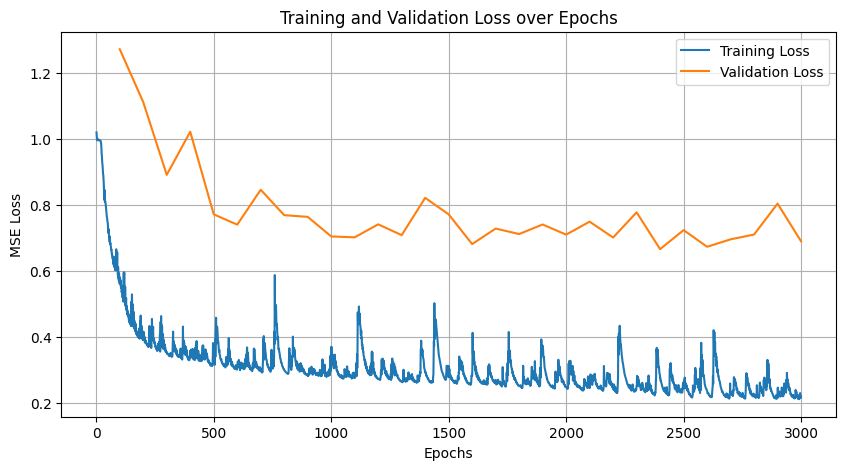

[I 2024-11-14 01:03:38,867] Trial 55 finished with value: 0.6907845139503479 and parameters: {'lr': 0.0062636891190876965, 'num_layers': 14, 'hidden_size': 27}. Best is trial 42 with value: 0.6270062327384949.


Learning Rate:  0.006337016002507434


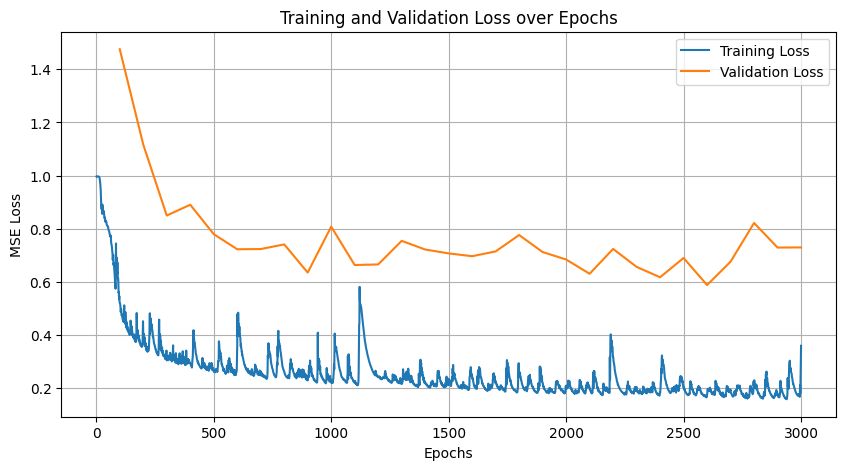

[I 2024-11-14 01:08:32,914] Trial 56 finished with value: 0.7292936444282532 and parameters: {'lr': 0.006337016002507434, 'num_layers': 14, 'hidden_size': 30}. Best is trial 42 with value: 0.6270062327384949.


Learning Rate:  0.008132506143472053


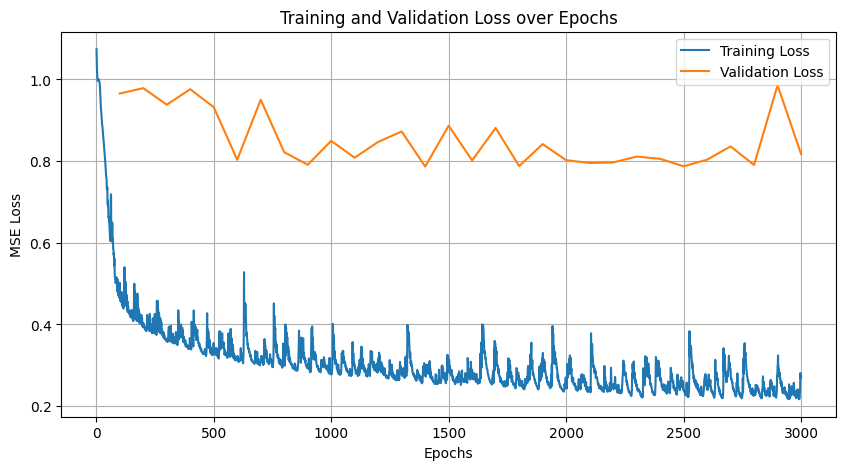

[I 2024-11-14 01:12:10,042] Trial 57 finished with value: 0.8175837993621826 and parameters: {'lr': 0.008132506143472053, 'num_layers': 12, 'hidden_size': 27}. Best is trial 42 with value: 0.6270062327384949.


Learning Rate:  0.00029757692367065


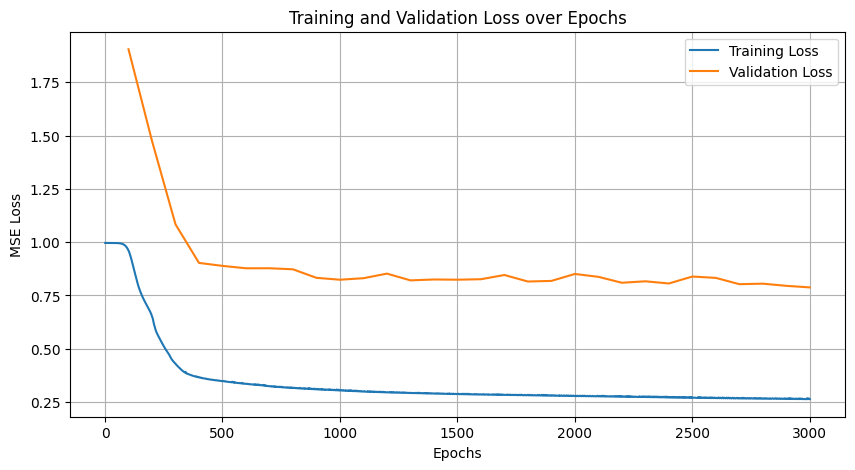

[I 2024-11-14 01:15:39,852] Trial 58 finished with value: 0.7878028154373169 and parameters: {'lr': 0.00029757692367065, 'num_layers': 11, 'hidden_size': 28}. Best is trial 42 with value: 0.6270062327384949.


Learning Rate:  0.0060881924422921075


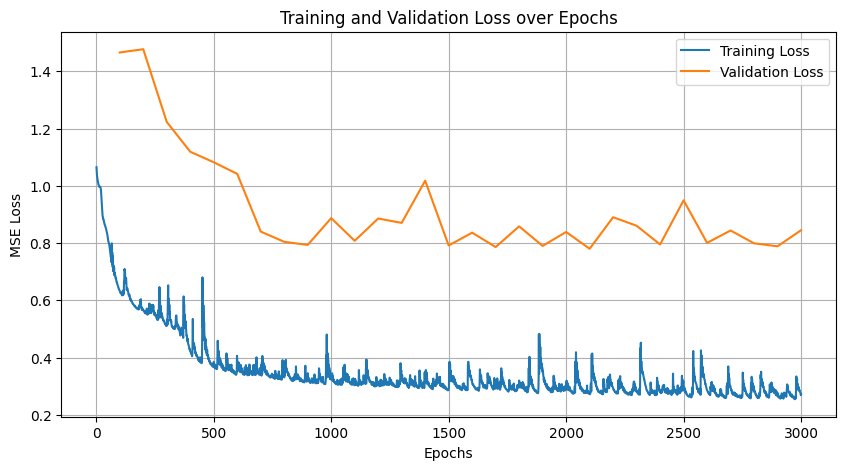

[I 2024-11-14 01:19:10,862] Trial 59 finished with value: 0.8448572754859924 and parameters: {'lr': 0.0060881924422921075, 'num_layers': 13, 'hidden_size': 25}. Best is trial 42 with value: 0.6270062327384949.


Learning Rate:  0.004029787707647244


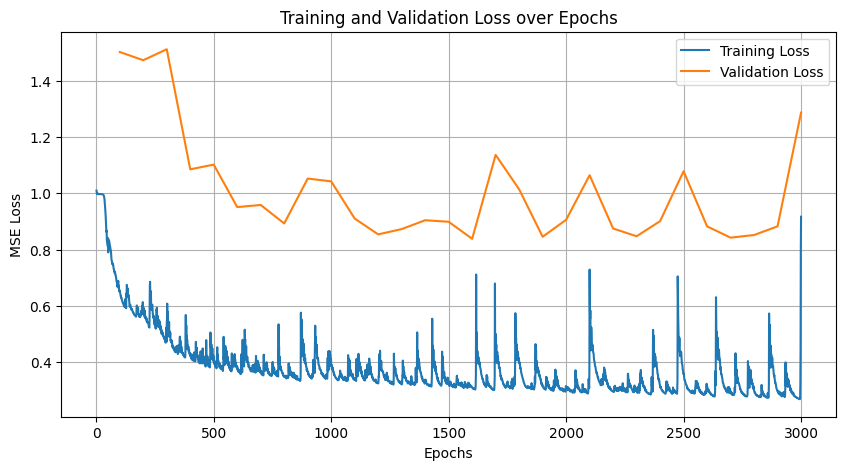

[I 2024-11-14 01:23:09,751] Trial 60 finished with value: 1.286024570465088 and parameters: {'lr': 0.004029787707647244, 'num_layers': 14, 'hidden_size': 26}. Best is trial 42 with value: 0.6270062327384949.


Learning Rate:  0.004633927228328244


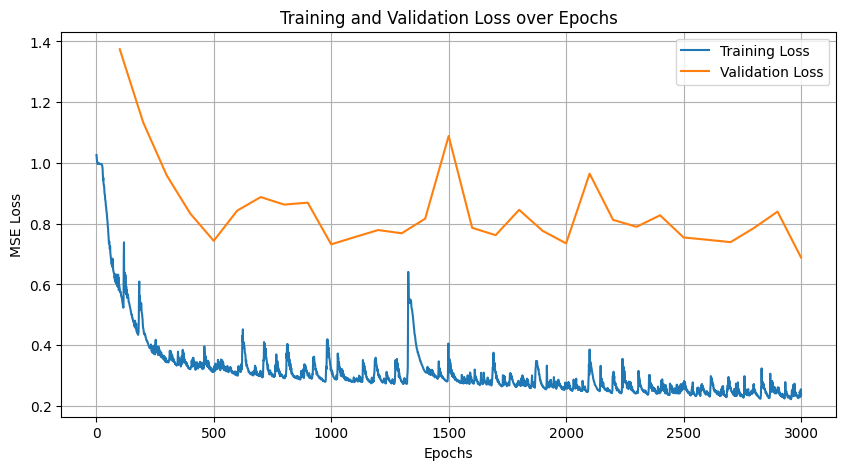

[I 2024-11-14 01:28:06,145] Trial 61 finished with value: 0.6888262033462524 and parameters: {'lr': 0.004633927228328244, 'num_layers': 15, 'hidden_size': 29}. Best is trial 42 with value: 0.6270062327384949.
[W 2024-11-14 01:32:46,766] Trial 62 failed with parameters: {'lr': 0.005376458208891711, 'num_layers': 16, 'hidden_size': 30} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-26-66222cd4cd82>", line 18, in objective
    outputs = model(X_train_small)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "<ipython-input-22-6730c6b9afbe>", line

KeyboardInterrupt: 

In [ ]:
def objective(trial):
    lr = trial.suggest_loguniform('lr', 1e-4, 1e-2)
    num_layers = trial.suggest_int('num_layers', 5, 16)
    hidden_size = trial.suggest_int('hidden_size', 11, 30)

    model = TrafficModel(input_size=X_train_small.shape[1],
                        hidden_sizes=[hidden_size] * num_layers,
                        output_size=1)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []

    for epoch in range(3000):
        model.train()
        optimizer.zero_grad()
        outputs = model(X_train_small)
        loss = criterion(outputs, y_train_small)
        train_losses.append(loss.item())
        loss.backward()
        optimizer.step()

        if (epoch + 1) % 100 == 0:
            model.eval()
            with torch.no_grad():
                val_outputs = model(X_test_small)
                val_loss = criterion(val_outputs, y_test_small)
                val_losses.append(val_loss.item())

    print("Learning Rate: ", lr)
    plt.figure(figsize=(10, 5))
    plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
    plt.plot(range(100, len(train_losses) + 1, 100), val_losses, label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('MSE Loss')
    plt.title('Training and Validation Loss over Epochs')
    plt.legend()
    plt.grid()
    plt.show()

    return val_losses[-1]

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=100)

print("Best hyperparameters: ", study.best_params)

# **Los mejores hiperparámetros serían:**

learning rate: 0.00455

número de capas ocultas: 13

número de neuronas por capa:  30

In [ ]:
# # Guardar todo el modelo
# torch.save(model, 'congestion_model_full.pth')
# # Crear el modelo de nuevo
# model = CongestionModel()

# # Cargar los pesos
# model.load_state_dict(torch.load('congestion_model.pth'))

# # Establecer el modelo en modo de evaluación (importante para inferencia)
# model.eval()

# # Datos para predecir (hora, clima, tráfico pasado)
# new_data = np.array([[10, 0, 3]])  # Ejemplo: hora 10 AM, clima soleado, tráfico moderado

# # Convertir los datos a tensor de PyTorch
# new_data_tensor = torch.tensor(new_data, dtype=torch.float32)

# # Hacer predicciones
# with torch.no_grad():  # No calcular gradientes para la predicción
#     predicted_congestion = model(new_data_tensor)
#     print(f'Predicción de congestión: {predicted_congestion.item()}%')


In [ ]:
lr = 0.00455
num_layers = 13
hidden_size = 30

model = TrafficModel(input_size=X_train.shape[1], hidden_sizes=[hidden_size] * num_layers, output_size=1)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

train_losses = []
val_losses = []

for epoch in range(3000):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    train_losses.append(loss.item())
    loss.backward()
    optimizer.step()

    if (epoch + 1) % 100 == 0:
        model.eval()
        with torch.no_grad():
            val_outputs = model(X_test_tensor)
            val_loss = criterion(val_outputs, y_test_tensor)
            val_losses.append(val_loss.item())

print("Learning Rate: ",lr)
plt.figure(figsize=(10, 5))
plt.plot(range(1, len(train_losses) + 1), train_losses, label='Training Loss')
plt.plot(range(100, len(train_losses) + 1, 100), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('MSE Loss')
plt.title('Training and Validation Loss over Epochs')
plt.legend()
plt.grid()
plt.show()
val_losses[-1]

Learning Rate:  0.00455


In [ ]:
Learning Rate:  0.00455
